# NBA Draft Pick Predictor

In [1]:
# Imports

import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

# Establish database connection
connection = sql.connect("ncaa_stats.db")

# Presets

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

# College Stats

## CSV -> SQL Table

In [2]:
# Load CSV to dataframe
import pandas as pd
cpdf = pd.read_csv("CollegeBasketballPlayers2009-2021.csv",low_memory=False)

# Cleaning
cpdf = cpdf.rename(columns={"Unnamed: 64": "position"})
cpdf = cpdf.drop("Unnamed: 65",axis=1)

_ = cpdf.to_sql("college_player_stats", connection, if_exists='replace', index=False)

## Preview Data for a Single Player (Pooh Williams)

In [3]:
# Note: There are 3 records for Pooh Williams in the table
# Each record of Pooh Williams indicates his stats for each season he played 
# yr attribute indicates player's year in college
display(pd.read_sql("SELECT * FROM college_player_stats WHERE player_name LIKE 'pooh williams'", connection))

player_name      team conf  GP  Min_per   Ortg   usg   eFG  TS_per  ORB_per  DRB_per  \
0  Pooh Williams  Utah St.  WAC  34     60.9  108.3  14.9  52.4   54.48      3.8      6.3   
1  Pooh Williams  Utah St.  WAC  32     64.0  108.3  18.1  53.0   53.33      2.3      5.9   
2  Pooh Williams  Utah St.  WAC  33     64.5  105.6  18.7  48.1   52.40      0.8      6.4   

   AST_per  TO_per  FTM  FTA  FT_per  twoPM  twoPA  twoP_per  TPM  TPA  TP_per  blk_per  stl_per  \
0     13.6    19.8   30   45   0.667     56    113     0.496   20   51   0.392      1.0      1.1   
1     14.6    14.1   33   62   0.532     70    134     0.522   36  100   0.360      0.9      1.4   
2     16.2    16.7   53   65   0.815     43    109     0.394   49  133   0.368      0.4      0.5   

    ftr  yr     ht   num   porpag    adjoe  pfr  year  pid type Rec Rank   ast/tov  rimmade  \
0  27.4  So  4-Jun  None  1.33492  100.066  3.4  2009    3  all     None  1.631621      NaN   
1  26.5  Jr  3-Jun     5  1.91528  104.792  2.7  2010    3  all     None  1.999909     48.0   
2  26.9  Sr  4-Jun     5  1.69879  103.899  2.9  2011    3  all     None  1.604681     30.0   

   rimmade+rimmiss  midmade  midmade+midmiss  rimmade/(rimmade+rimmiss)  \
0              NaN      NaN              NaN                        NaN   
1             75.0     22.0             59.0                     0.6400   
2             56.0     13.0             53.0                     0.5357   

   midmade/(midmade+midmiss)  dunksmade  dunksmiss+dunksmade  dunksmade/(dunksmade+dunksmiss)  \
0                        NaN        NaN                  NaN                              NaN   
1                     0.3729        6.0                  7.0                           0.8571   
2                     0.2453        6.0                  7.0                           0.8571   

   pick     drtg     adrtg  dporpag    stops       bpm     obpm      dbpm      gbpm       mp  \
0  None  105.078  104.0170  1.88003  111.929  0.593024  1.38549 -0.792469 -0.300196  24.5294   
1  None  100.875   98.5761  2.63663  124.827  2.282520  2.42698 -0.144461  1.062230  27.3125   
2  None   97.301   96.2795  2.74423  118.019  1.125160  1.10920  0.015963  1.546720  26.0000   

      ogbpm     dgbpm    oreb    dreb    treb     ast     stl     blk     pts position  
0 -0.052263 -0.247934  0.6765  1.2647  1.9412  1.8235  0.4118  0.2353  5.9412     None  
1  0.785960  0.276271  0.4688  1.3750  1.8438  2.1875  0.5938  0.2188  8.7812  Combo G  
2  0.860731  0.685989  0.1515  1.4848  1.6364  2.0909  0.2121  0.0909  8.6667  Combo G

## Checking for Duplicates to Verify pid is a UID among Drafted NBA Players

In [4]:
# Create dataframe with a unique record for each drafted NBA player
drafted_df = pd.read_sql("SELECT DISTINCT pid, player_name FROM college_player_stats WHERE pick NOT NULL", connection)

print('Dataframe containing players who changed their names during different seasons:')
# pid holds as a UID despite the player's name changes
display(drafted_df[drafted_df['pid'].duplicated(keep=False)].groupby("pid", group_keys=True).apply(lambda x:x))

print('Dataframe containing different players with the same full names:')
# pid holds as a UID despite players having duplicate full names
display(cpdf[cpdf['pid'].isin(drafted_df[drafted_df['player_name'].duplicated(keep=False)]['pid'])].groupby("player_name", group_keys=True).apply(lambda x:x)[['pid', 'player_name', 'team', 'yr', 'year']])

# SIGNIFICANCE: pid does hold as a UID

Dataframe containing players who changed their names during different seasons:


pid         player_name
pid                                 
13567 128  13567     Tyshawn  Taylor
      171  13567      Tyshawn Taylor
14026 129  14026      MarShon Brooks
      175  14026      Marshon Brooks
14888 190  14888     Tim Hardaway Jr
      237  14888    Tim Hardaway Jr.
21042 132  21042  Robbie John Hummel
      185  21042       Robbie Hummel
25301 281  25301     DeAndre Daniels
      294  25301     Deandre Daniels
31965 352  31965      Deandre Bembry
      404  31965     DeAndre' Bembry
38703 359  38703        Monté Morris
      407  38703        Monte Morris
41006 360  41006         Frank Mason
      435  41006     Frank Mason III
41594 441  41594        O.G. Anunoby
      456  41594          OG Anunoby
41745 443  41745    Raymond Spalding
      457  41745        Ray Spalding
46262 477  46262         Bruce Brown
      508  46262     Bruce Brown Jr.
47002 401  47002       Vince Edwards
      482  47002     Vincent Edwards
50678 520  50678    Temetrius Morant
      554  50678           Ja Morant
51924 547  51924        Kezie Okpala
      555  51924           KZ Okpala
65906 579  65906      Robert Woodard
      598  65906   Robert Woodard II

Dataframe containing different players with the same full names:


pid      player_name            team  yr  year
player_name                                                            
Justin Jackson  31555  36922   Justin Jackson  North Carolina  Fr  2015
                34856  36922   Justin Jackson  North Carolina  So  2016
                38541  36922   Justin Jackson  North Carolina  Jr  2017
                41131  47108   Justin Jackson        Maryland  Fr  2017
                44469  47108   Justin Jackson        Maryland  So  2018
Marcus Thornton 1847    3395  Marcus Thornton             LSU  Sr  2009
                16495  19793  Marcus Thornton  William & Mary  Fr  2012
                19926  19793  Marcus Thornton  William & Mary  So  2013
                23795  19793  Marcus Thornton  William & Mary  Jr  2014
                27897  19793  Marcus Thornton  William & Mary  Sr  2015

## Previewing College Statistics of Drafted NBA Players

In [5]:
display(pd.read_sql("""SELECT player_name, team, conf, GP, Min_per, Ortg, usg, eFG, TS_per, ORB_per,
DRB_per, AST_per, TO_per, FTM, FTA, FT_per, twoPM, twoPA, twoP_per, TPM,
TPA, TP_per, blk_per, stl_per, ftr, yr, ht, num, porpag, adjoe, pfr,
year, pid, type, [Rec Rank], [ast/tov], rimmade, [rimmade+rimmiss], midmade,
[midmade+midmiss], [rimmade/(rimmade+rimmiss)], [midmade/(midmade+midmiss)], dunksmade,
[dunksmiss+dunksmade], [dunksmade/(dunksmade+dunksmiss)], pick, drtg, adrtg,
dporpag, stops, bpm, obpm, dbpm, gbpm, mp, ogbpm, dgbpm, oreb, dreb,
treb, ast, stl, blk, pts, position
FROM college_player_stats WHERE pick NOT NULL GROUP BY pid""", connection).head())

player_name         team conf  GP  Min_per   Ortg   usg   eFG  TS_per  ORB_per  DRB_per  \
0  Charles Jenkins      Hofstra  CAA  31     86.2  104.3  30.8  43.1   50.76      2.7     11.9   
1   Vernon Macklin      Florida  SEC  34     62.5  116.3  19.8  60.7   60.85     11.9     12.9   
2        Ryan Reid  Florida St.  ACC  35     47.4   82.0  19.7  44.0   48.56      9.5     12.4   
3     Kyle Singler         Duke  ACC  37     80.4  111.8  26.0  51.4   54.90     10.6     16.7   
4      Nolan Smith         Duke  ACC  34     49.5  105.3  20.6  48.5   53.84      3.5      8.0   

   AST_per  TO_per  FTM  FTA  FT_per  twoPM  twoPA  twoP_per  TPM  TPA  TP_per  blk_per  stl_per  \
0     32.6    18.5  183  223   0.821    166    396     0.419   30   94   0.319      1.4      2.4   
1      6.5    16.2   47   80   0.588    156    257     0.607    0    0   0.000      3.5      1.4   
2      7.9    32.2   48   76   0.632     62    141     0.440    0    0   0.000      3.8      2.0   
3     15.5    17.0  124  174   0.713    139    292     0.476   69  180   0.383      3.1      2.8   
4     15.2    20.9   62   73   0.849     71    152     0.467   27   78   0.346      0.3      2.5   

    ftr  yr      ht   num    porpag     adjoe  pfr  year  pid type  Rec Rank   ast/tov  rimmade  \
0  45.5  So   3-Jun  None  4.021670  117.8840  3.1  2009   57  all       NaN  1.276195      NaN   
1  31.1  Jr  10-Jun    32  3.140360  120.7210  3.8  2010   91  all      95.0  0.565230    121.0   
2  53.9  Jr   8-Jun  None  0.032054   84.7537  4.2  2009  193  all      82.0  0.361139      NaN   
3  36.9  So   8-Jun  None  4.714590  126.5120  3.3  2009  197  all      99.0  0.967384      NaN   
4  31.7  So   2-Jun  None  2.015530  111.2350  3.8  2009  198  all      95.8  1.054587      NaN   

   rimmade+rimmiss  midmade  midmade+midmiss  rimmade/(rimmade+rimmiss)  \
0              NaN      NaN              NaN                        NaN   
1            164.0     35.0             93.0                     0.7378   
2              NaN      NaN              NaN                        NaN   
3              NaN      NaN              NaN                        NaN   
4              NaN      NaN              NaN                        NaN   

   midmade/(midmade+midmiss)  dunksmade  dunksmiss+dunksmade  dunksmade/(dunksmade+dunksmiss)  \
0                        NaN        NaN                  NaN                              NaN   
1                     0.3763       42.0                 45.0                           0.9333   
2                        NaN        NaN                  NaN                              NaN   
3                        NaN        NaN                  NaN                              NaN   
4                        NaN        NaN                  NaN                              NaN   

   pick     drtg    adrtg  dporpag    stops       bpm     obpm      dbpm      gbpm       mp  \
0  44.0  97.5891  98.6127  3.30834  199.390  3.422580  2.77553  0.647047  4.614900  35.0323   
1  52.0  99.6269  95.2206  2.71272  150.896  5.302160  3.56420  1.737970  4.855430  25.2647   
2  57.0  95.6378  89.4357  2.42557  125.834  0.297536 -3.12407  3.421610 -0.868858  19.1143   
3  33.0  92.1514  86.4901  4.43913  255.606  9.729550  6.10049  3.629060  9.212470  32.2703   
4  21.0  97.6446  92.0009  2.56099  124.644  2.858910  2.19660  0.662308  2.655750  21.6176   

     ogbpm    dgbpm    oreb    dreb    treb     ast     stl     blk      pts position  
0  3.44840  1.16650  0.9032  3.8387  4.7419  4.3226  1.4194  0.4516  19.5161     None  
1  3.80201  1.05341  2.6765  2.8529  5.5294  0.7647  0.5882  0.8529  10.5588        C  
2 -2.97775  2.10889  1.4857  2.2286  3.7143  0.7429  0.6571  0.6571   4.9143     None  
3  6.73951  2.47296  3.0270  4.6486  7.6757  2.4054  1.5405  1.0270  16.4595     None  
4  1.06775  1.58800  0.6765  1.5000  2.1765  1.7059  0.9412  0.0588   8.3824     None

## Information on Advanced Stats

Information from https://www.basketball-reference.com/about/glossary.html

Note: twoPM (2 Pointers Made) vs. TPM (3 Pointers Made)

Ortg (Offensive Production Rating) = $\frac{Points Produced}{Individual Possessions} × OAPOW × PPG + \frac{FTM}{FT} * 3pt\% + FG\%$

usg (Usage Rate) = $\frac{Possessions\ Ended\ by\ Player}{Total\ Team\ Possessions\ with\ Player\ on\ Court} × 100\%$

eFG% (Effective Field Goal Percentage) = $\frac{FG + 0.5 * 3P}{FGA}$

TS% (True Shooting Percentage) = $\frac{PTS}{2(FGA + 0.44 * FTA)}$

TO% (Turnover Percentage) = $\frac{TO*100}{FGA+FTA*0.44+AST+TO}$

BLK% (Block Percentage) = $ \frac{100 * BLK * \frac{Tm\ MP}{5}}{MP(Opp\ FGA - Opp\ 3PA)}$ Tm = Team, MP = Minutes Played

ftr (Free Throw Rate) = $ \frac{FTA}{FGA}$

adjoe (Adjusted Offensive Efficiency) = Points per 100 possessions adjusted for opponent

Drtg (Defensive Rating) = $Team\ Defensive\ Rating + 0.2 (100 * D\ Pts\ per\ ScPoss (1 - Stop\%) - Team\ Defensive\ Rating)$ 

bpm (Box Plus Minus) = a box score estimate of the points per 100 possessions that a player contributed above a league-average player

RPI (Rating Percentage Index) = Ratings for each conference based on their W/L records. 

## Loading and Preparing Data for Random Forest Regressor

In [6]:
ncaa_df = pd.read_sql("SELECT * FROM college_player_stats WHERE pick NOT NULL GROUP BY pid, year", connection)

# Prepping ncaa_df to be consistent with conference and team rating data scraped from teamrankings.com

ncaa_df["team"] = list(map(lambda x: re.sub("[.']", "", x), ncaa_df["team"])) # Getting rid of periods and apostrophes in team names
ncaa_df["conf"] = ncaa_df["conf"].replace('P10','P12') # Pac10 is the old name of Pac12
ncaa_df[ncaa_df["player_name"] == 'Stephen Curry'] = ncaa_df[ncaa_df["player_name"] == 'Stephen Curry'].replace('SC','A10') # Moved to the right conference
ncaa_df[ncaa_df["player_name"] == 'Andrew Goudelock'] = ncaa_df[ncaa_df["player_name"] == 'Andrew Goudelock'].replace('SC','CAA') # Moved to the right conference

# replace_dicts are used to reformat conference & team names from teamrankings.com to match the format of ncaa_df

conf_replace_dict = {'Atlantic 10': 'A10',
                     'Big 12': 'B12', 
                     'Big Ten': 'B10', 
                     'Mountain West': 'MWC', 
                     'Big East': 'BE', 
                     'Pac-12': 'P12', 
                     'American': 'Amer',
                     'Sun Belt': 'SB',
                     'Big West': 'BW',
                     'Summit': 'Sum',
                     'Big Sky': 'BSky',
                     'Horizon League': 'Horz',
                     'Patriot': 'Pat',
                     'Ohio Valley': 'OVC'}

team_replace_dict = {'Boston College': 'Boston Col',
                     'Bowling Green': 'Bowling Grn',
                     'College of Charleston': 'Col Charlestn',
                     'East Carolina': 'E Carolina',
                     'Eastern Washington': 'E Washingtn',
                     'Georgia Tech': 'GA Tech',
                     'Green Bay': 'WI-Grn Bay',
                     'Long Beach St': 'Lg Beach St',
                     'Louisiana Lafayette': 'Lafayette',
                     'Louisiana Tech': 'LA Tech',
                     'Loyola MD': 'Loyola-MD',
                     'Massachusetts': 'U Mass',
                     'Miami FL': 'Miami',
                     'Mississippi St': 'Miss State',
                     'New Mexico St': 'N Mex State',
                     'North Carolina': 'N Carolina',
                     'North Carolina St': 'NC State',
                     'Northern Illinois': 'N Illinois',
                     'SMU': 'S Methodist',
                     'Saint Josephs': 'St Josephs',
                     'Saint Marys': 'St Marys',
                     'South Carolina': 'S Carolina',
                     'South Dakota St': 'S Dakota St',
                     'South Florida': 'S Florida',
                     'St Bonaventure': 'St Bonavent',
                     'TCU': 'TX Christian',
                     'Tennessee Martin': 'TN Martin',
                     'Tennessee Tech': 'TN Tech',
                     'UC Santa Barbara': 'UCSB',
                     'UT Arlington': 'TX-Arlington',
                     'UTEP': 'TX El Paso',
                     'Virginia Tech': 'VA Tech',
                     'Washington St': 'Wash State',
                     'West Virginia': 'W Virginia',
                     'Western Kentucky': 'W Kentucky',
                     'William & Mary': 'Wm & Mary'}
team_replace_dict = {v: k for k, v in team_replace_dict.items()} # Switch keys and values because I put them in the wrong order


def create_strength_dict(ncaa_df, replace_dict, year, group): #create a dictionary with key=ncaa_df index, value=strength rating for a certain year
    if group == 'conference':
        conf_df = pd.read_html(f"https://www.teamrankings.com/ncaa-basketball/rpi-ranking/rpi-rating-by-conf?date={year}-04-04")[0] # Scraping conference rating table for associated year from teamrankings.com
        conf_df = conf_df.replace('--',np.nan) # Replace -- with Null values
        conf_df = conf_df.replace({'Conference': replace_dict}) # Reformat conference names with replace dict
        conf_dict = dict(zip(conf_df["Conference"],conf_df["Rating"].astype("float"))) # Create a dictionary with key=conference and value=conference rating for the associated year
        return ncaa_df[ncaa_df["year"]==year].replace({"conf": conf_dict})["conf"].to_dict() # Create a dictionary with key=ncaa_df index and value=conference rating for the associated year
    elif group == 'team':
        team_df = pd.read_html(f"https://www.teamrankings.com/ncaa-basketball/ranking/predictive-by-other/?date={year}-04-04")[0] # Scraping team rating table for associated year from teamrankings.com
        team_df["Team"] = list(map(lambda x: re.sub("\s\(.+","",x), team_df["Team"])) # Get rid of any parentheses text in team names
        team_df = team_df.replace({'Team': replace_dict}) # Reformat team names with replace dict
        team_dict = dict(zip(team_df["Team"], team_df["Rating"].astype("float"))) # Create a dictionary with key=team and value=team rating for the associated year
        return ncaa_df[ncaa_df["year"]==year].replace({"team": team_dict})["team"].to_dict() # Create a dictionary with key=ncaa_df index and value=team rating for the associated year

conf_strength_dict = {}
team_strength_dict = {}
years = ncaa_df["year"].sort_values().unique()
for year in years:
    conf_strength_dict |= create_strength_dict(ncaa_df, conf_replace_dict, year, 'conference') # Adding new values to conf_strength_dict
    team_strength_dict |= create_strength_dict(ncaa_df, team_replace_dict, year, 'team') # Adding new values to team_strength_dict
conf_str = [record[1] for record in sorted(conf_strength_dict.items())] # conf_str = values sorted by ncaa_df index
team_str = [record[1] for record in sorted(team_strength_dict.items())] # team_str = values sorted by ncaa_df index
ncaa_df.insert(2, "team_str", team_str) # Adding team strength to the ncaa_df
ncaa_df.insert(4, "conf_str", conf_str) # Adding conference strength to the ncaa_df

# Encoding each position as 0,1,2,...,8
from sklearn.preprocessing import LabelEncoder
ncaa_df['position'] = LabelEncoder().fit_transform(ncaa_df['position'])

# Making a new dataframe with attributes weighted on minutes per game
weighted_df = ncaa_df.copy()
weighted_df = weighted_df[weighted_df["pid"].duplicated()==False]
weighted_df = weighted_df.set_index("pid")

# Declare stats that should be weighted averaged
def weighted_avg(df, values, weights): # Code from https://www.statology.org/pandas-weighted-average/
    v = df[values]
    w = df[weights]
    return (v * w).sum() / w.sum()

unweightable_stats = ["player_name","team","team_str","conf","conf_str","GP","yr","ht","num","year","pid","type","pick","mp","position"]
weightable_stats = [ele for ele in weighted_df.columns if ele not in unweightable_stats]

for stat in weightable_stats:
    weighted_df[stat] = ncaa_df.groupby("pid").apply(weighted_avg, stat, "Min_per") # Weighted average of weightable_stats over the seasons the player played
for stat in ["team_str", "conf_str", "GP"]: # Stats that will be averaged (instead of weighted averaged)
    weighted_df[stat] = ncaa_df.groupby("pid")[stat].mean() # Average over the seasons the player played


# !!!!!
# Idea to Improve Performance: Weight on multiple variables (conf_str, team_str, Min_per) by doing (d * w1 * w2 * w3).sum() / (w1 * w2 * w3).sum()
# !!!!!

# Normalizing weighted_df between 0 & 1

unwanted_stats = ["player_name","team","conf","yr","ht","num","year","pid","type","pick","position"]
wanted_stats = [ele for ele in ncaa_df.columns if ele not in unwanted_stats] # Declare stats that should be normalized

from sklearn.preprocessing import MinMaxScaler
for stat in wanted_stats:
    weighted_df[stat] = MinMaxScaler().fit_transform(np.array(weighted_df[stat]).reshape(-1,1))

## Heatmap Plotting Corrleation Between Each (Weighted Averaged) Attribute

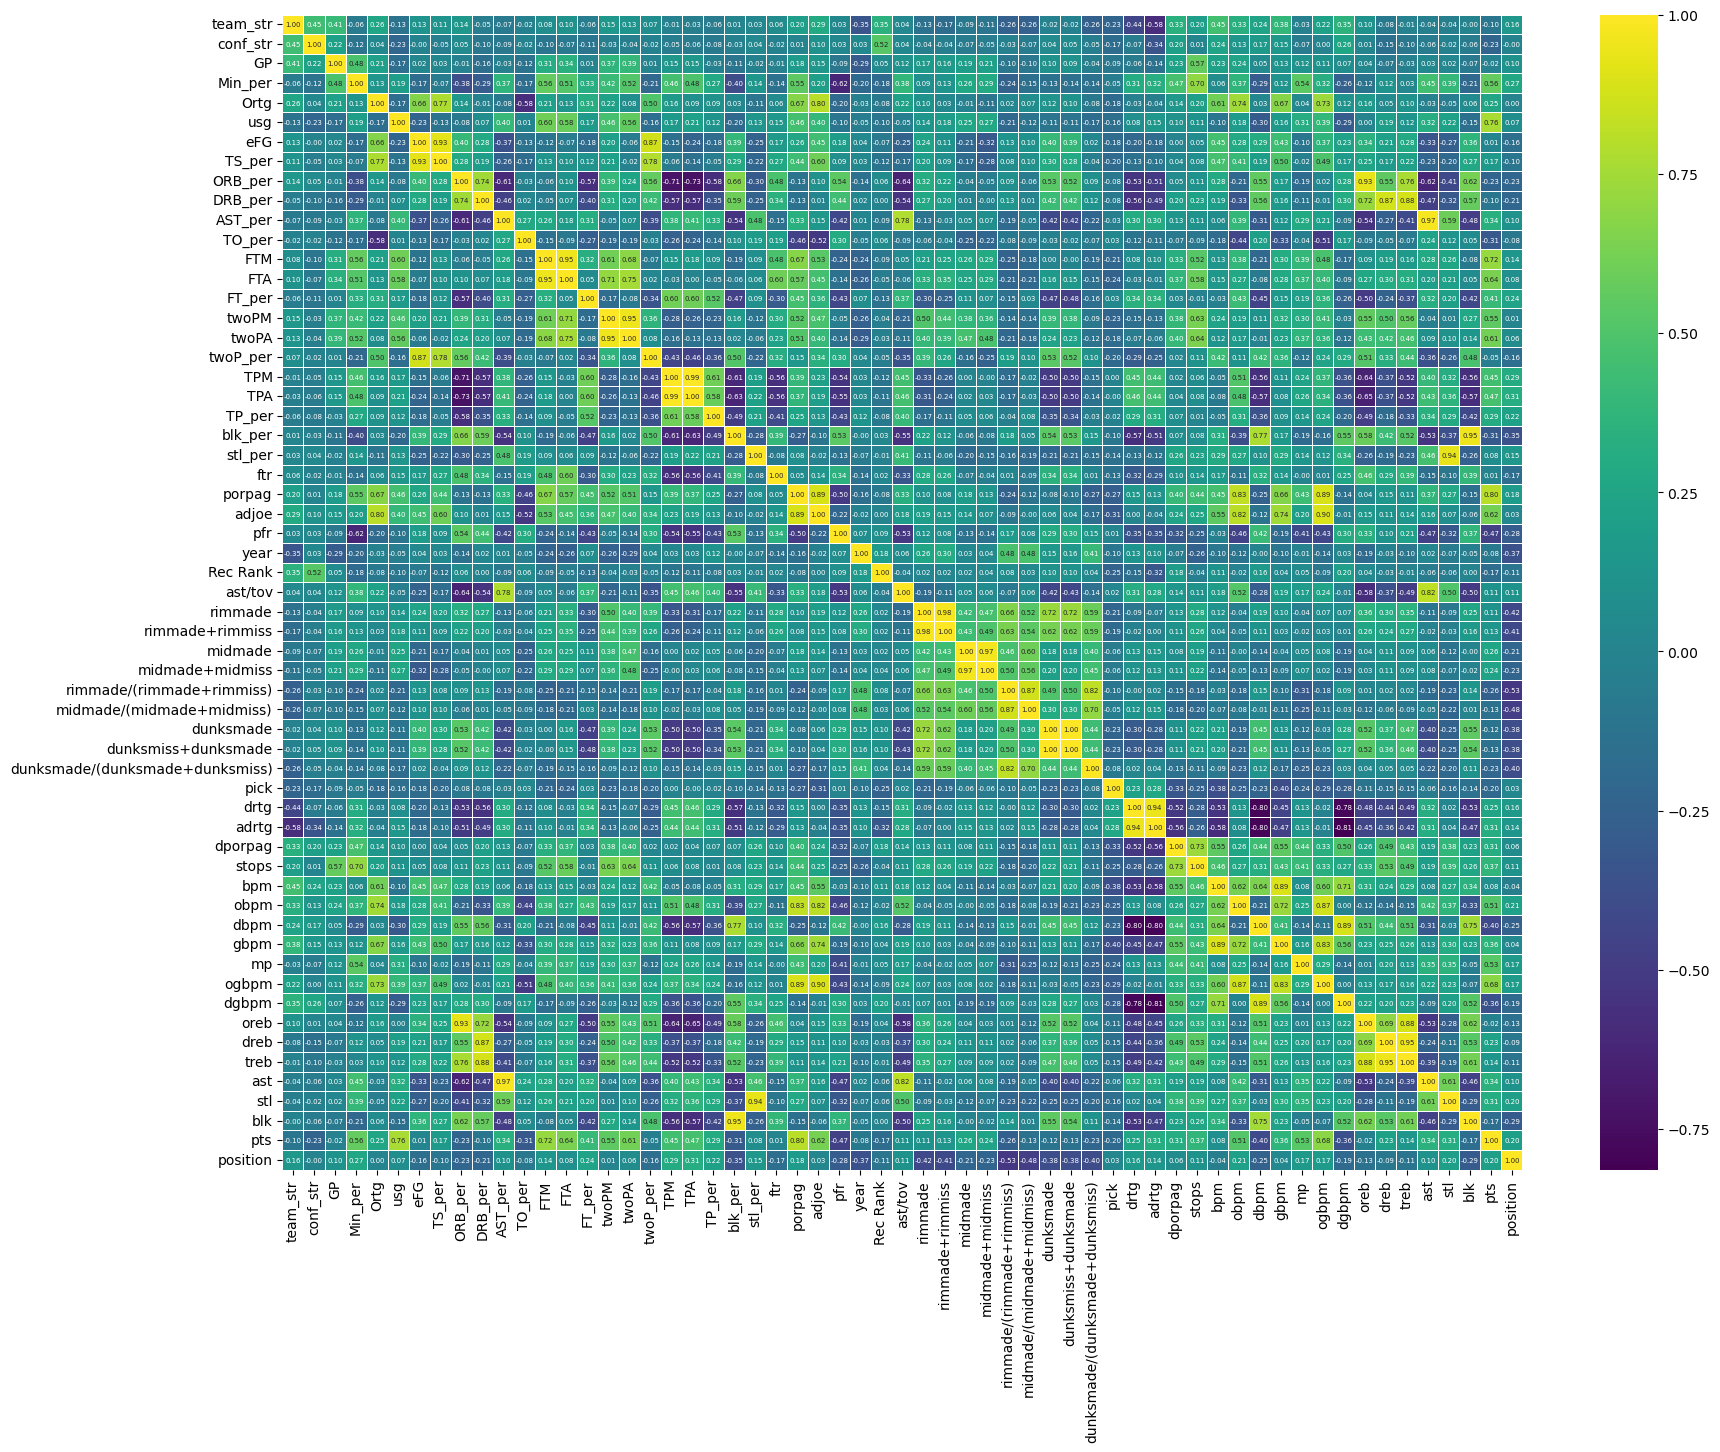

In [7]:
plt.figure(figsize=(20, 15))
sns.heatmap(weighted_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='viridis', annot_kws={'size': 5}, linewidth=0.5)
plt.show()

## Scatterplot of Each Attribute vs. Pick (Search for Correlation)

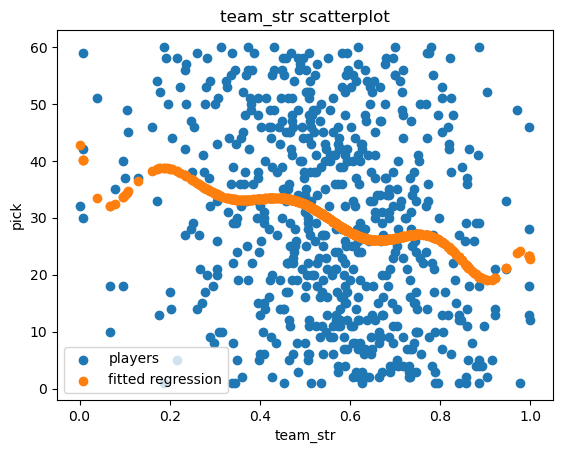

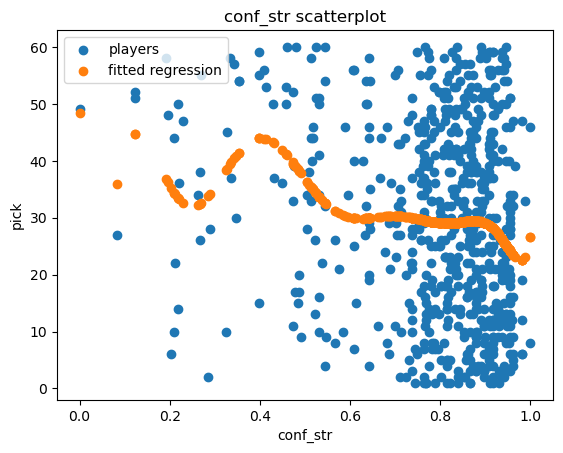

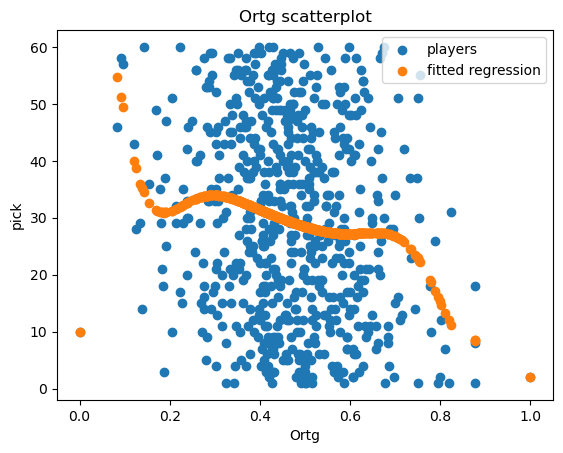

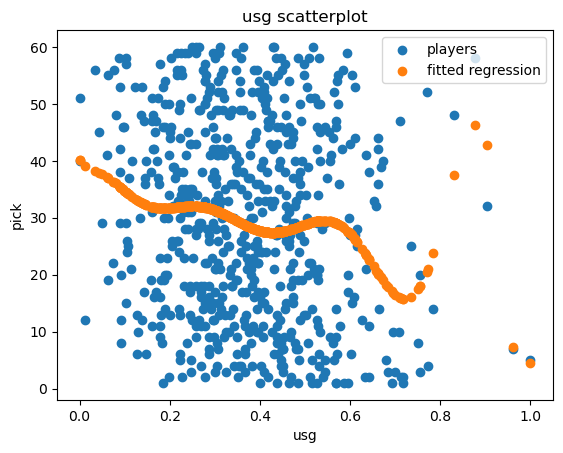

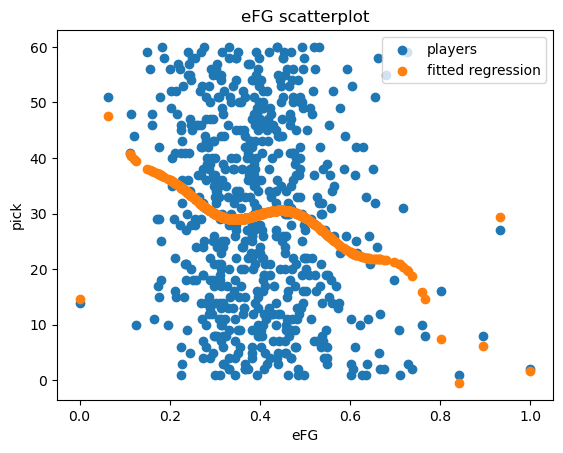

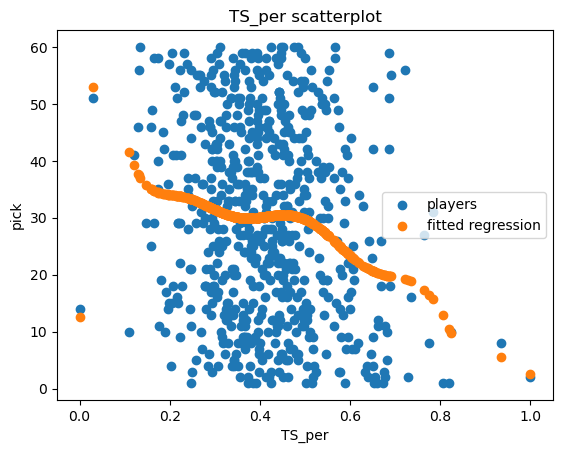

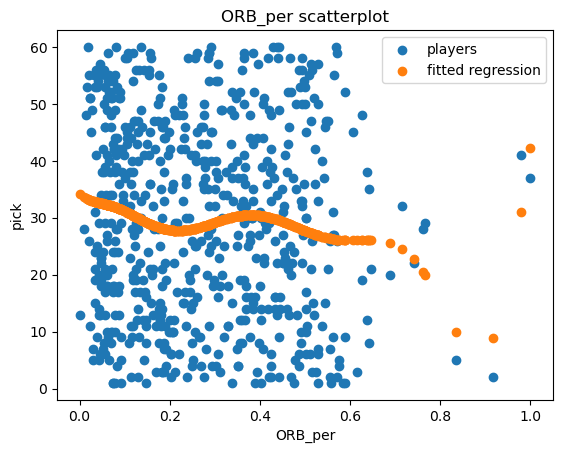

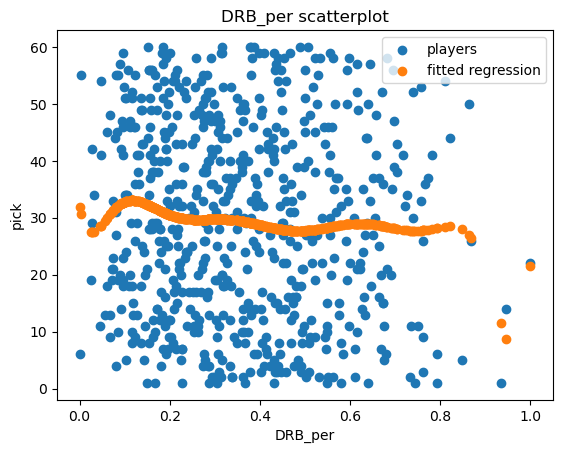

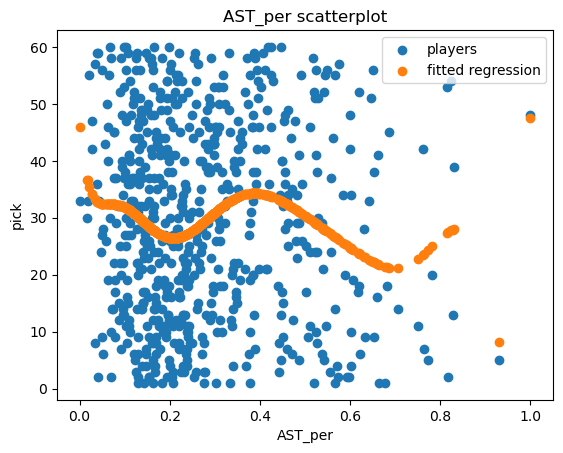

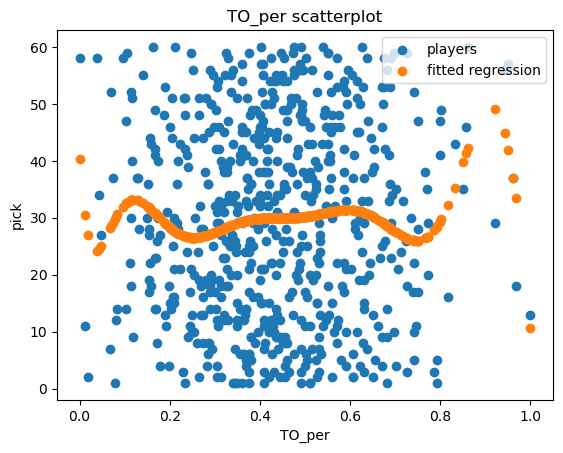

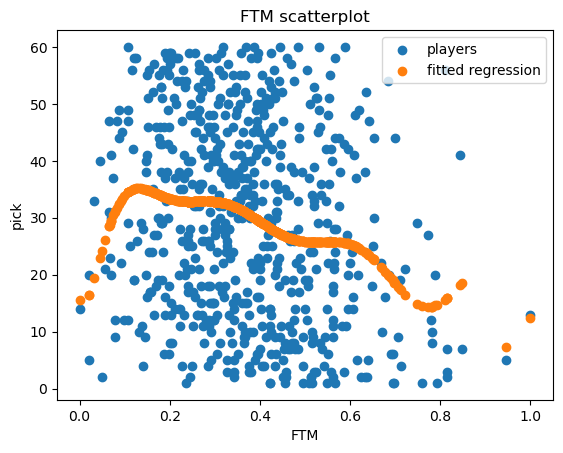

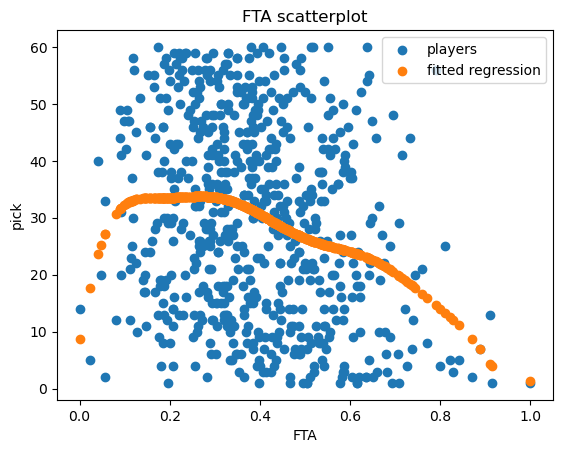

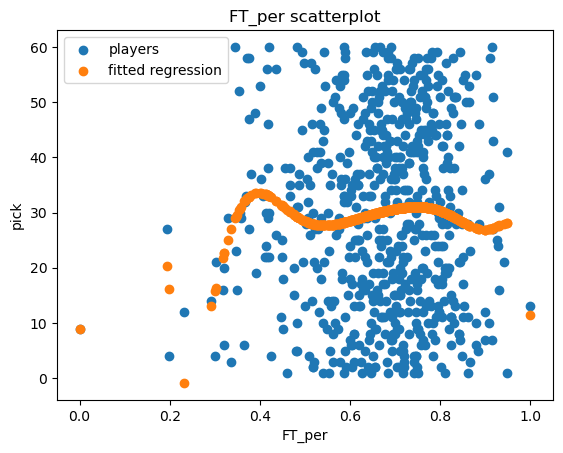

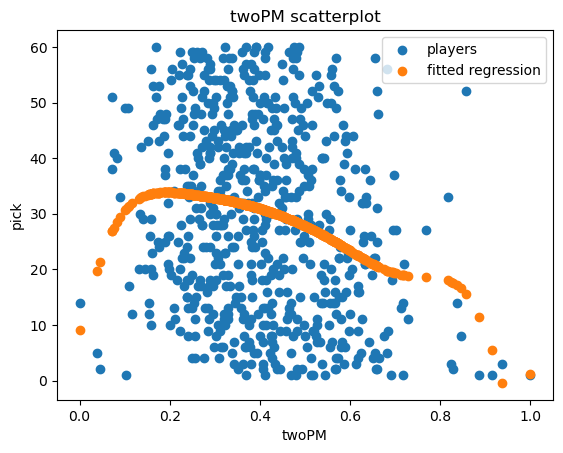

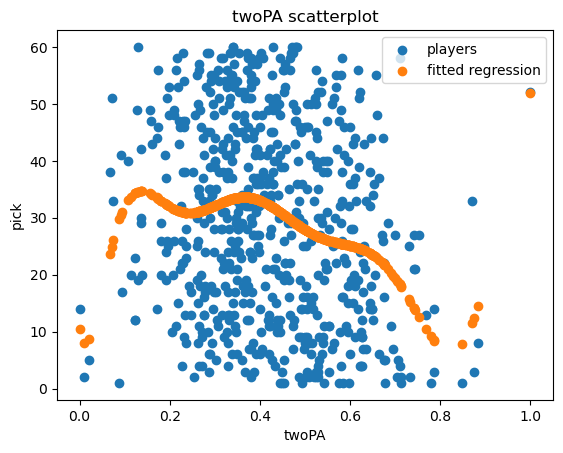

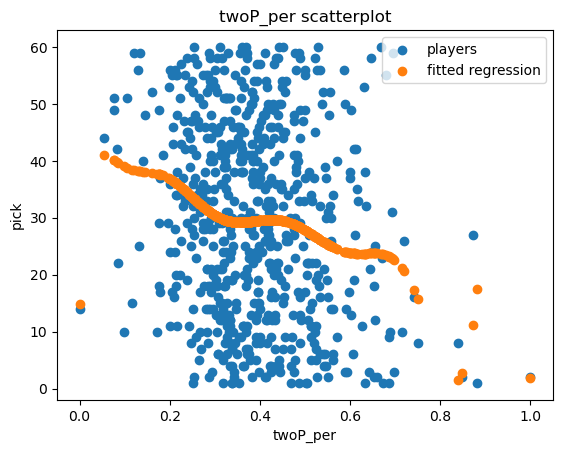

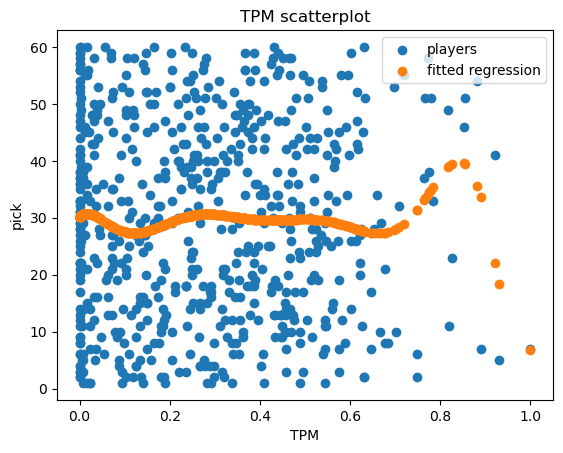

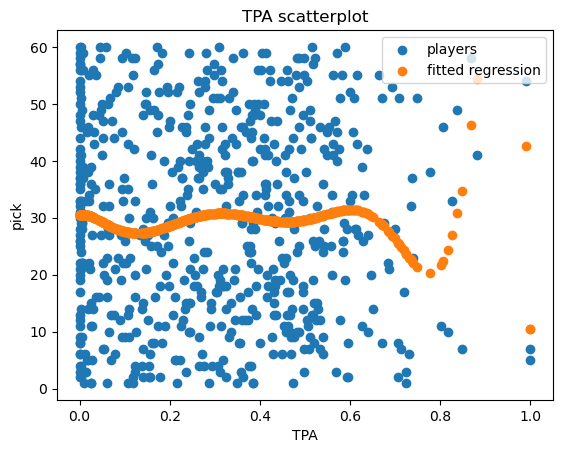

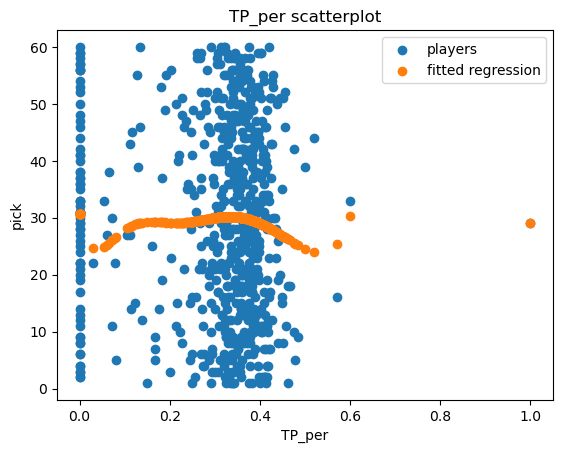

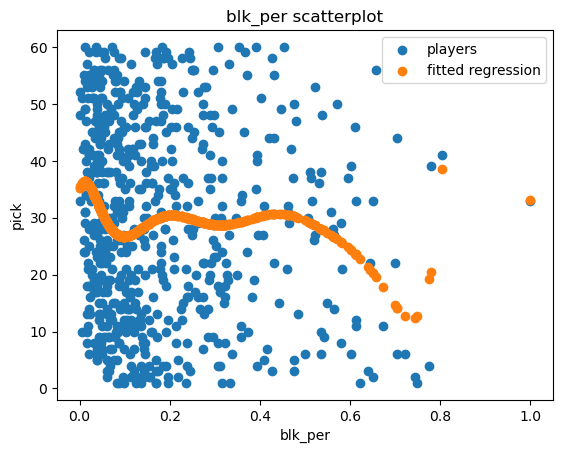

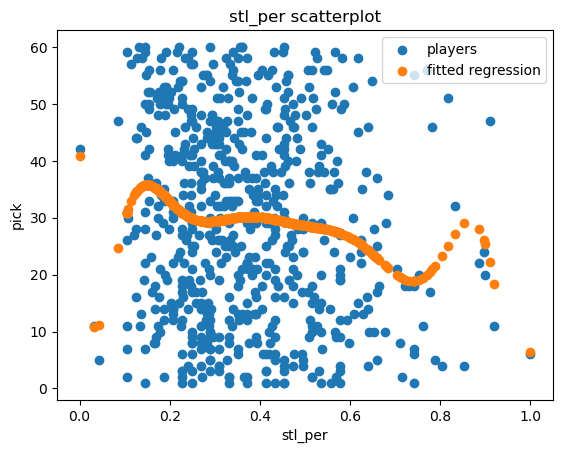

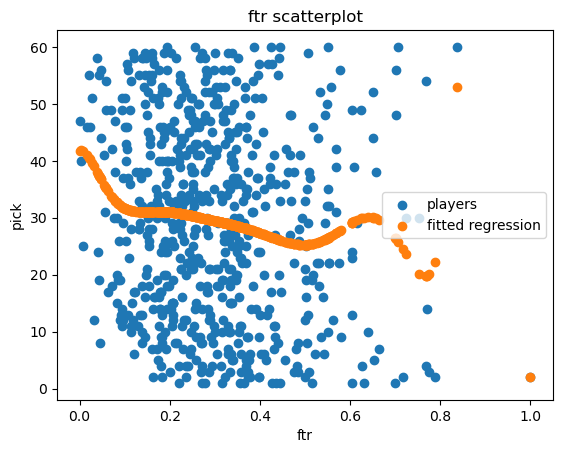

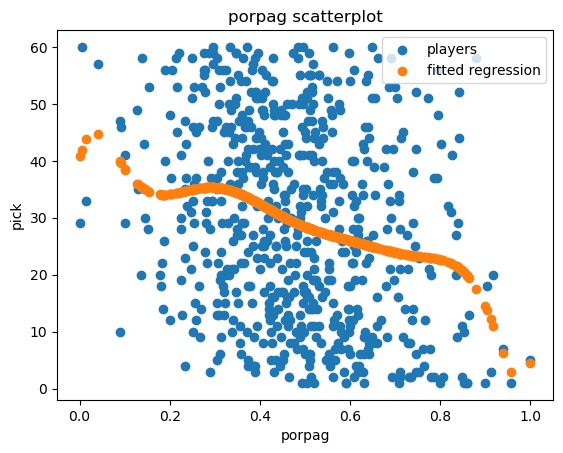

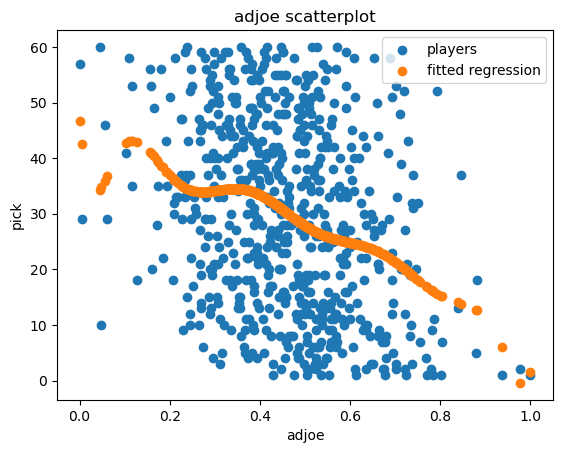

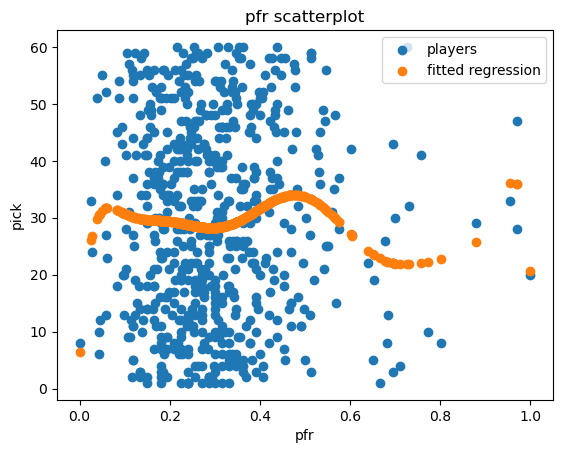

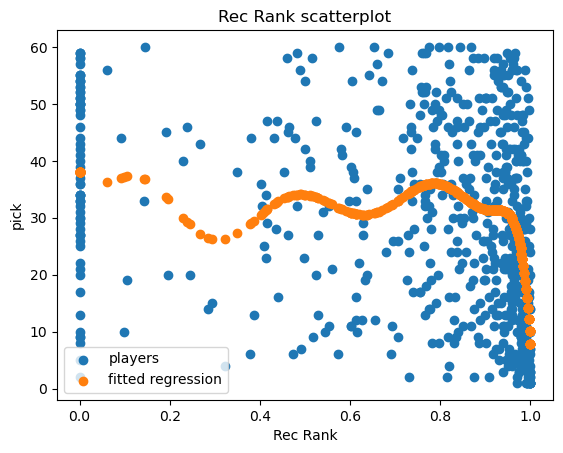

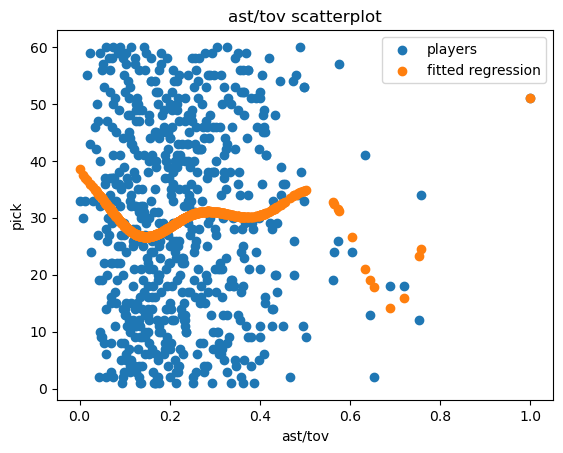

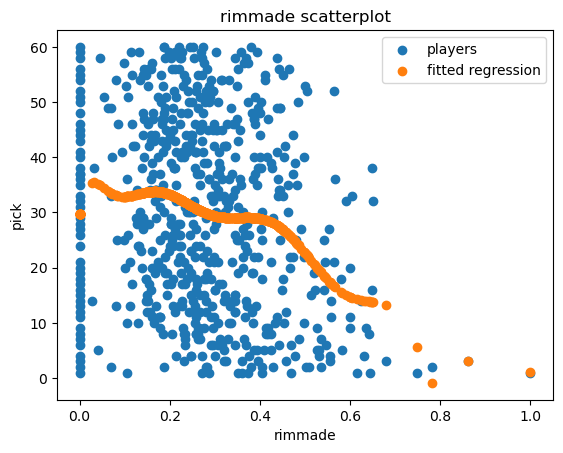

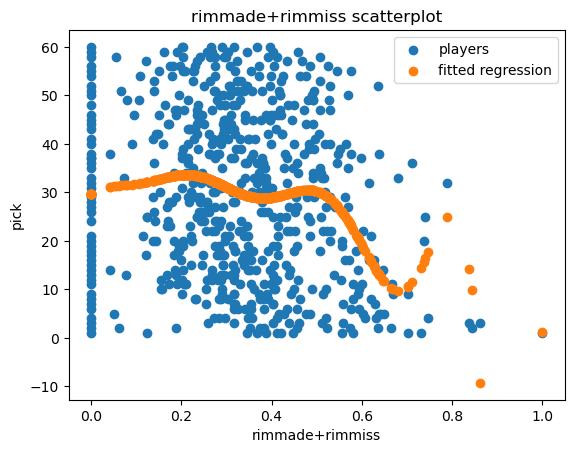

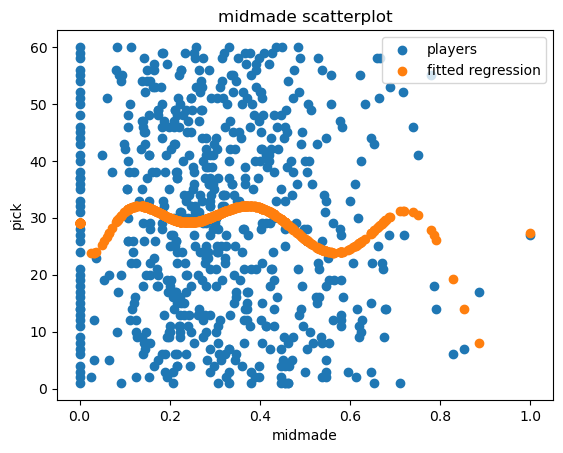

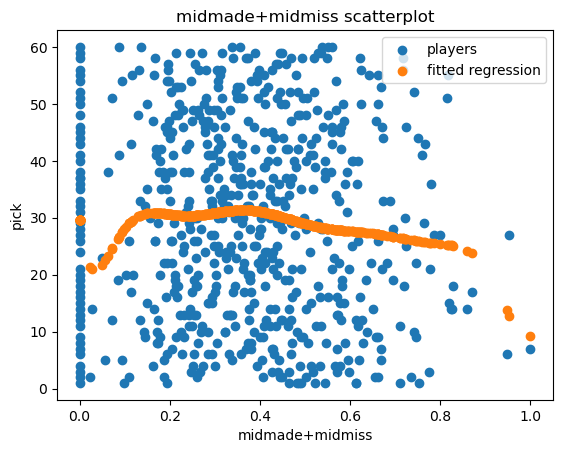

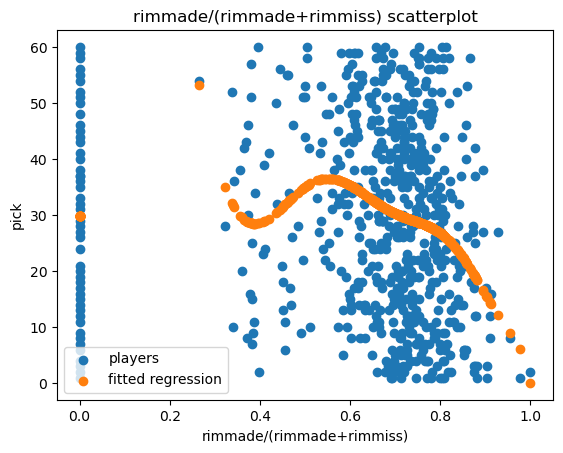

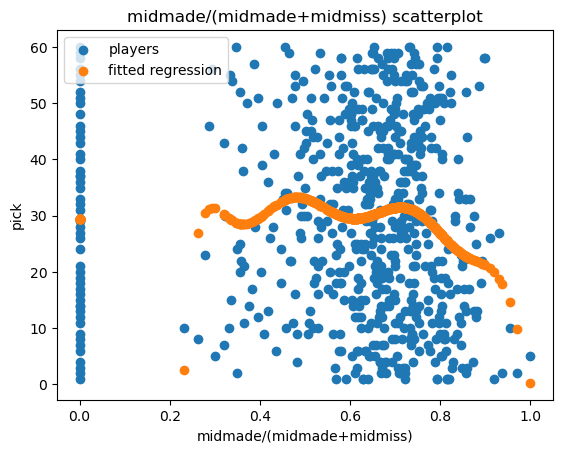

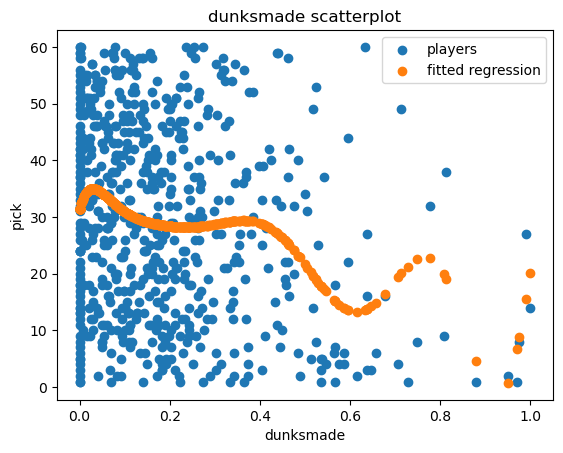

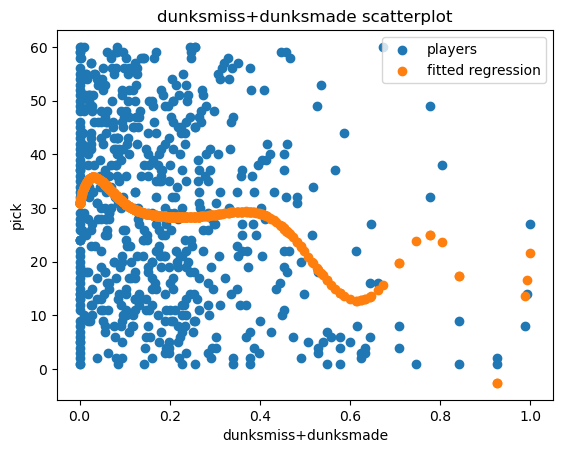

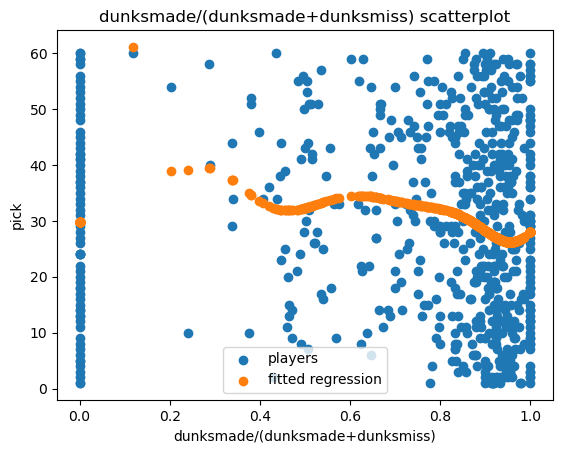

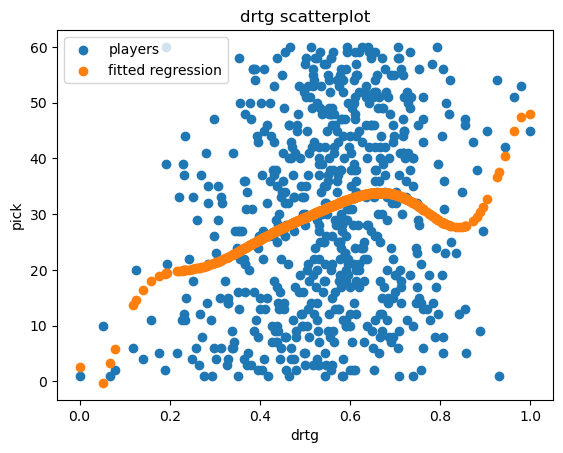

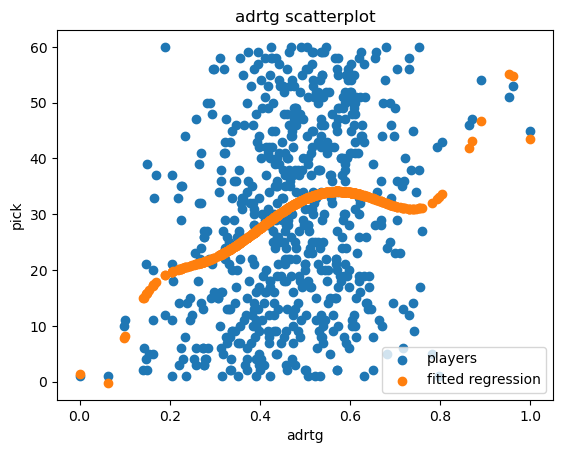

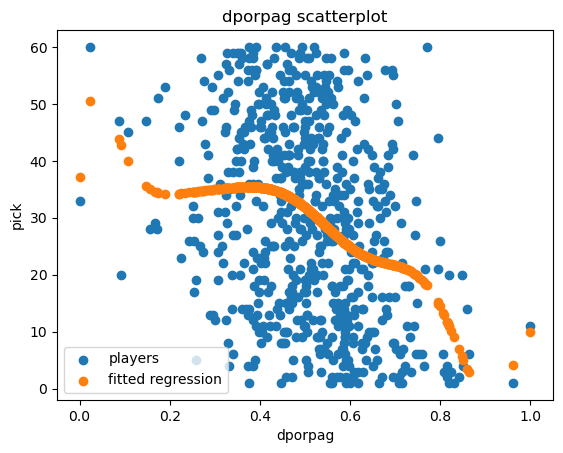

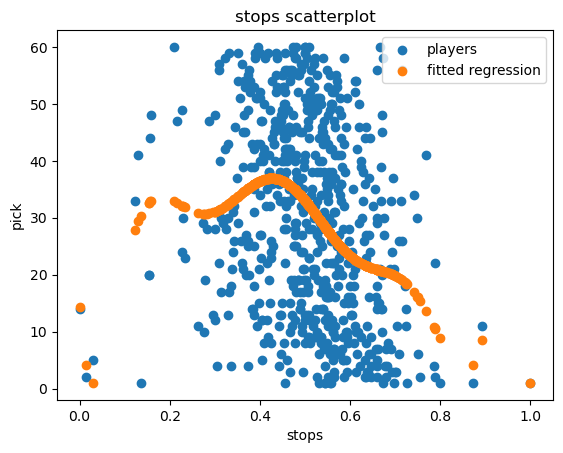

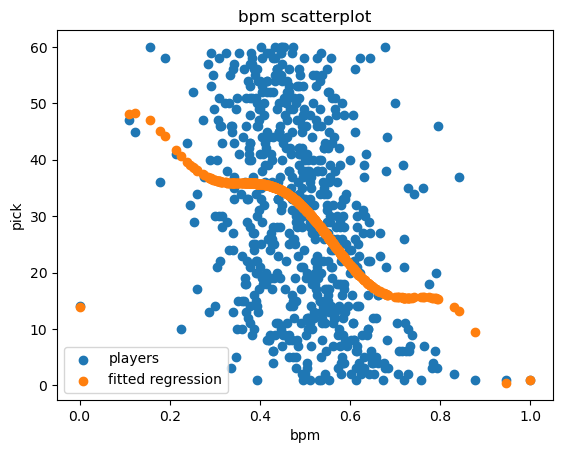

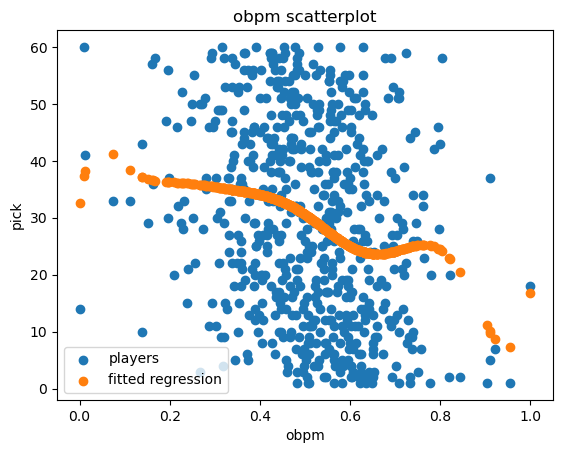

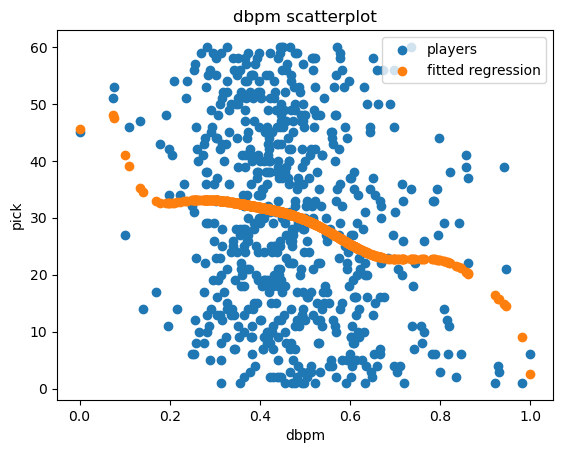

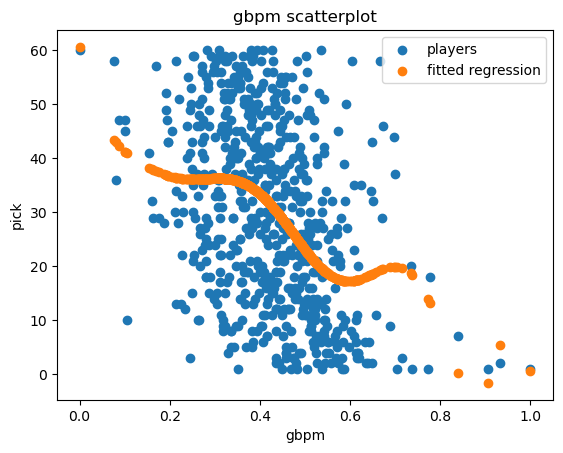

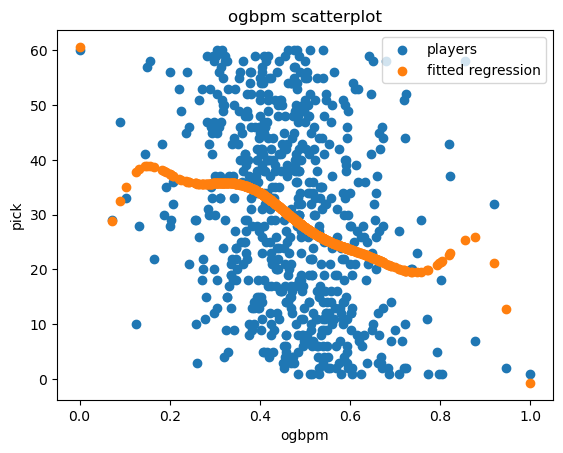

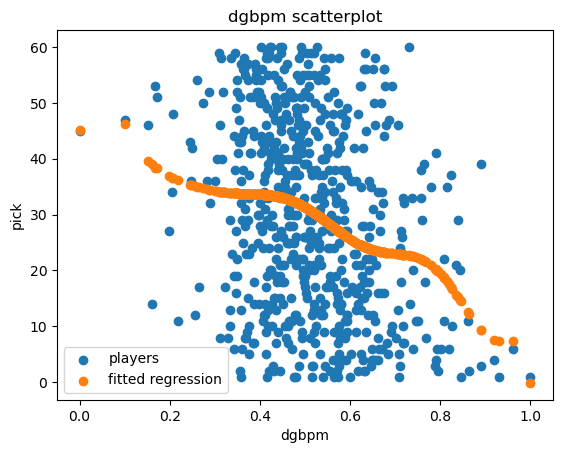

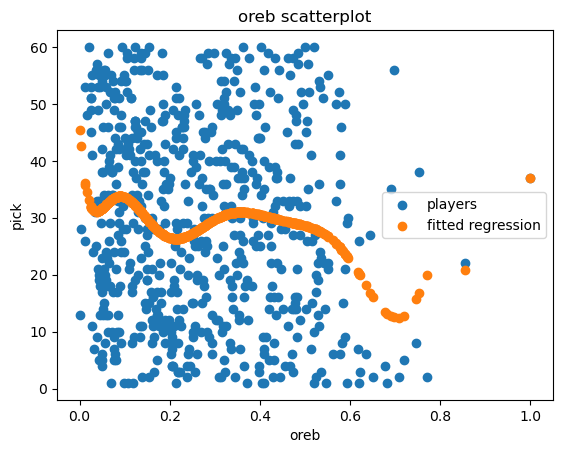

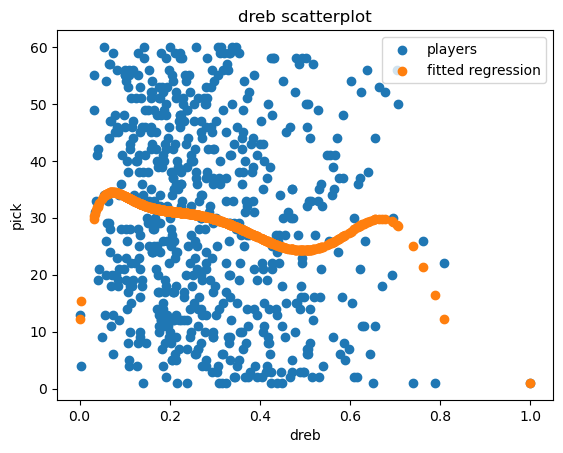

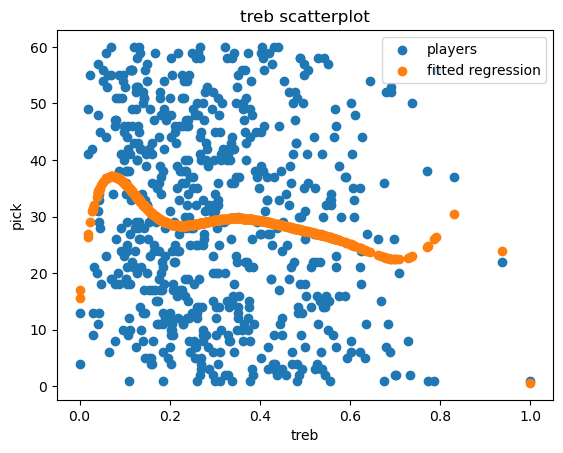

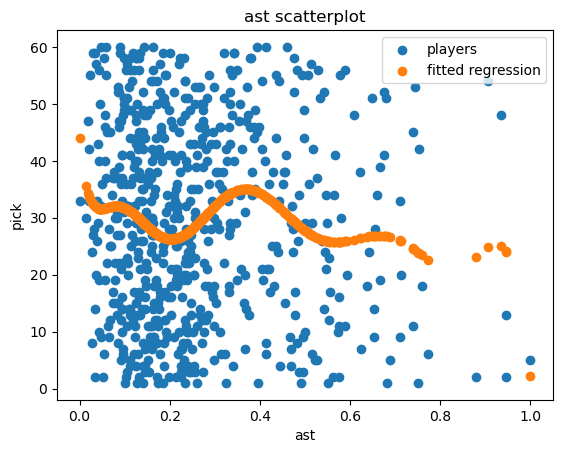

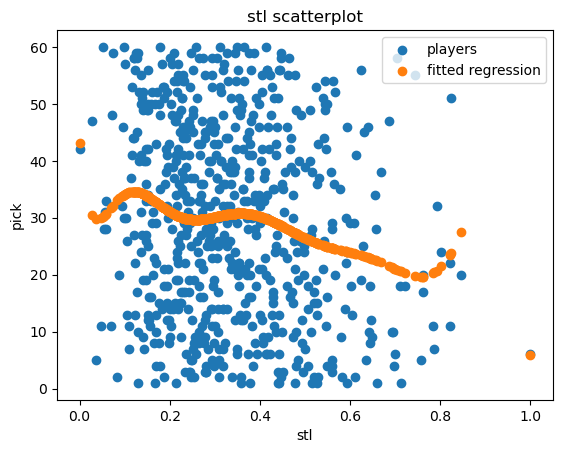

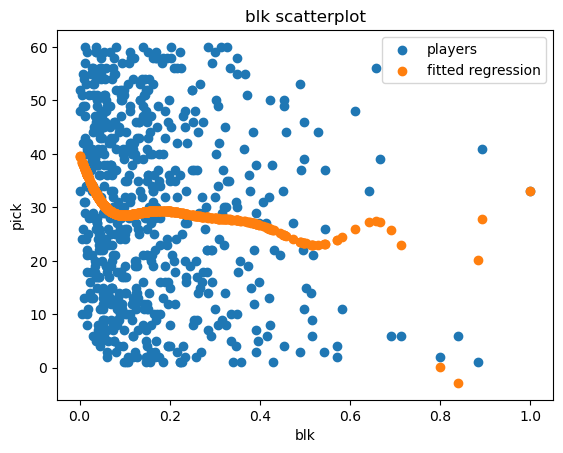

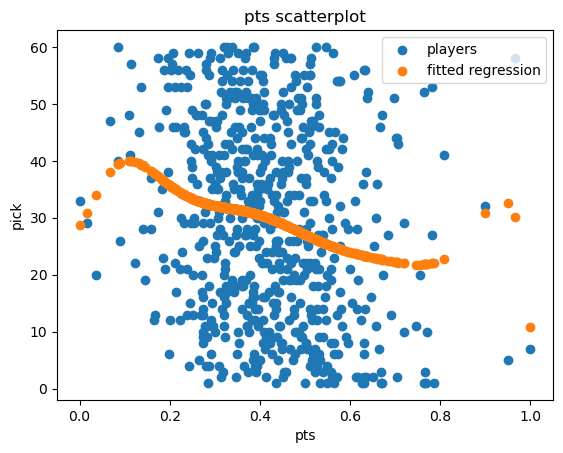

In [8]:
# Logistic Regression Scatterplot over all relevant statistics
def scat_polyfit(df,statx,staty): # Creating a Scatterplot of the associated stats within the given DataFrame
    x = df[statx]
    y = df[staty]
    y_predicted = [np.poly1d(np.polyfit(x, y, 10))(i) for i in x]
    
    plt.title(statx+' scatterplot')
    plt.xlabel(statx)
    plt.ylabel(staty)
    plt.scatter(x,y,label='players')
    plt.scatter(x,y_predicted,label='fitted regression')
    plt.legend()
    plt.show()

unwanted_stats = ["player_name","team","conf","GP","Min_per","yr","ht","num","year","pid","type","pick","mp","position"]
wanted_stats = [ele for ele in ncaa_df.columns if ele not in unwanted_stats]
for stat in wanted_stats:
    scat_polyfit(weighted_df,stat,"pick")

## Histograms of Each Attribute (Validate Data by Viewing Distributions)

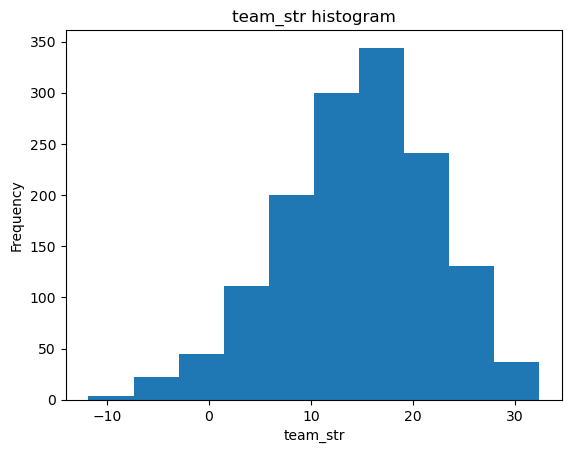

min: -11.8, max: 32.4, mean: 14.709686411149827, median: 15.3, stdev: 7.60137142432884


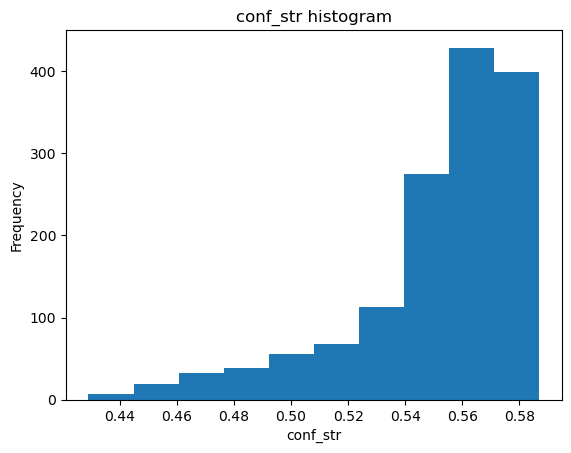

min: 0.429, max: 0.587, mean: 0.5517372822299651, median: 0.559, stdev: 0.03023547699833889


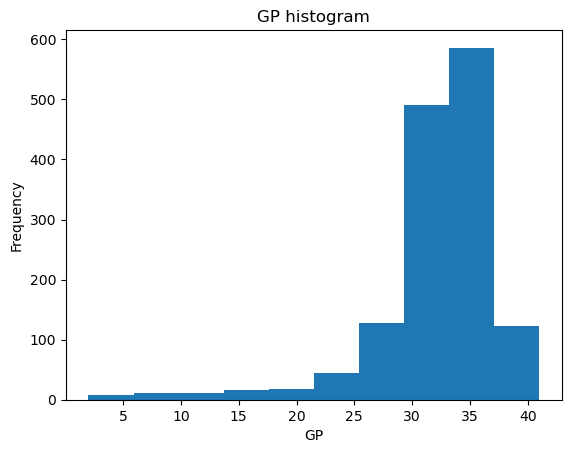

min: 2, max: 41, mean: 32.3205574912892, median: 33.0, stdev: 5.488833825150508


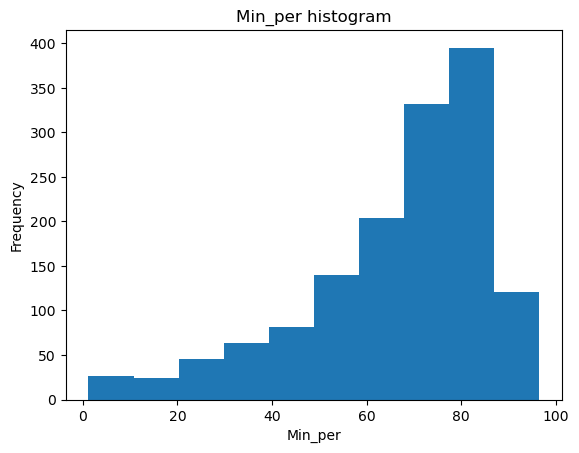

min: 1.2, max: 96.5, mean: 66.495818815331, median: 72.2, stdev: 19.577828715300466


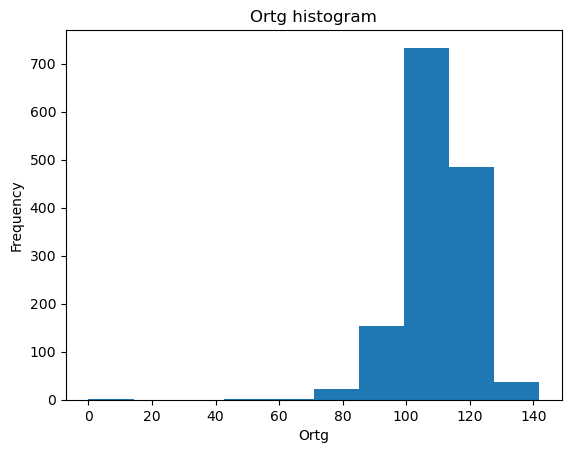

min: 0.0, max: 141.9, mean: 109.99526132404182, median: 110.4, stdev: 10.278470267018745


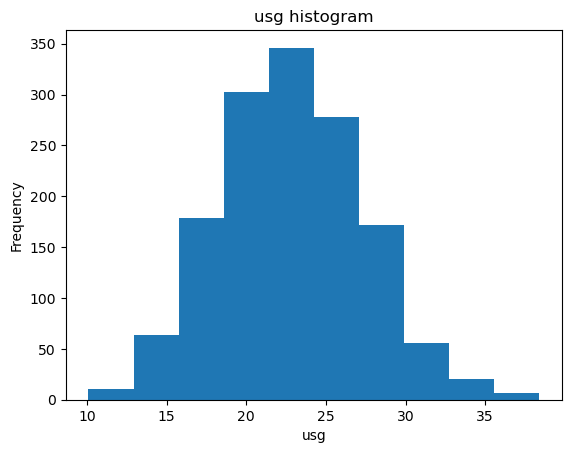

min: 10.1, max: 38.4, mean: 22.823135888501742, median: 22.6, stdev: 4.49280937109292


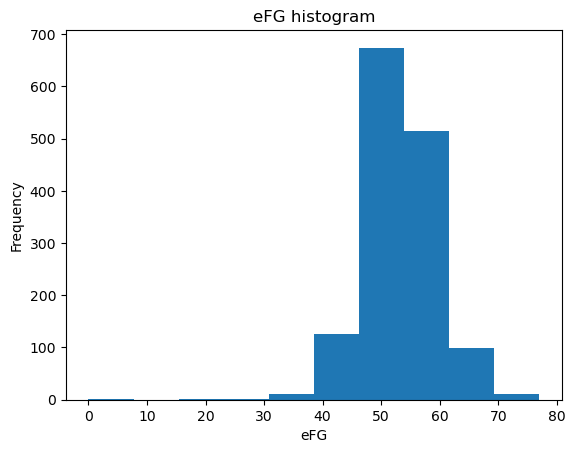

min: 0.0, max: 77.0, mean: 53.082926829268295, median: 52.9, stdev: 6.0571137855384825


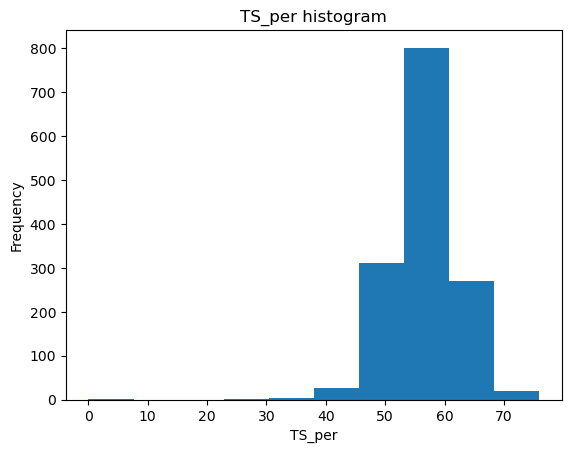

min: 0.0, max: 75.98, mean: 56.524731707317066, median: 56.64, stdev: 5.508671595019653


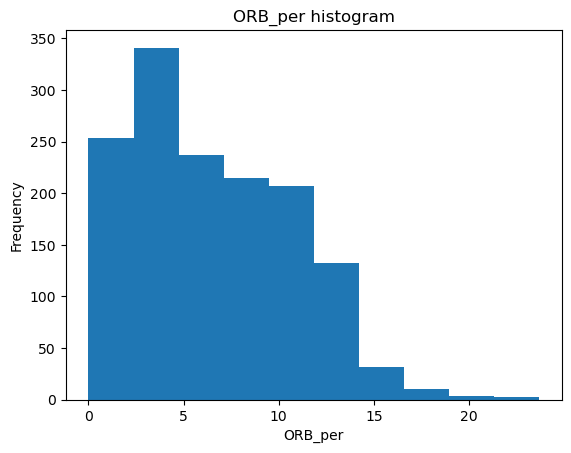

min: 0.0, max: 23.7, mean: 6.608919860627177, median: 5.9, stdev: 4.123106118281567


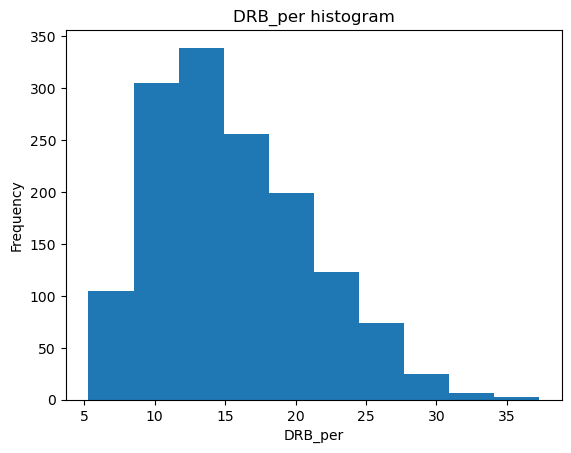

min: 5.3, max: 37.3, mean: 15.473170731707317, median: 14.5, stdev: 5.4912036335677215


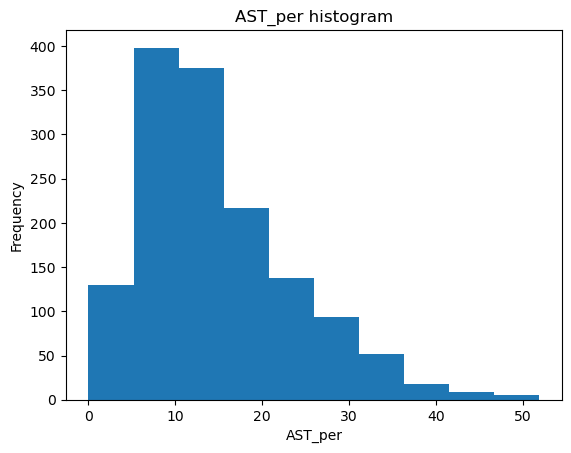

min: 0.0, max: 51.9, mean: 14.758118466898956, median: 12.6, stdev: 8.899058642013154


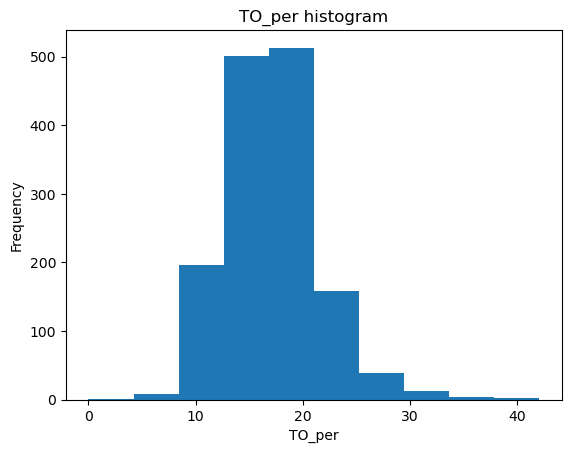

min: 0.0, max: 42.1, mean: 17.16885017421603, median: 16.9, stdev: 4.373637074240838


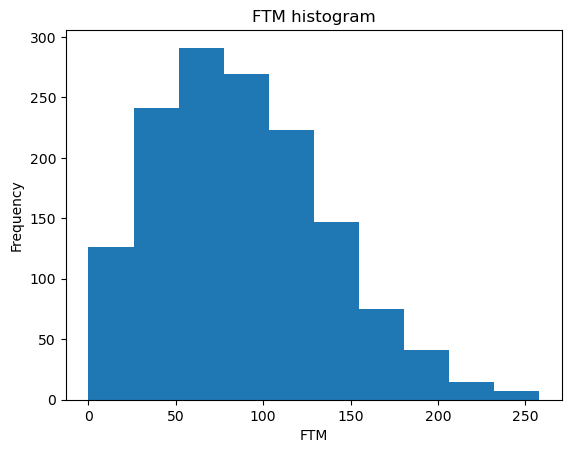

min: 0, max: 258, mean: 87.69407665505227, median: 84.0, stdev: 48.214382794604894


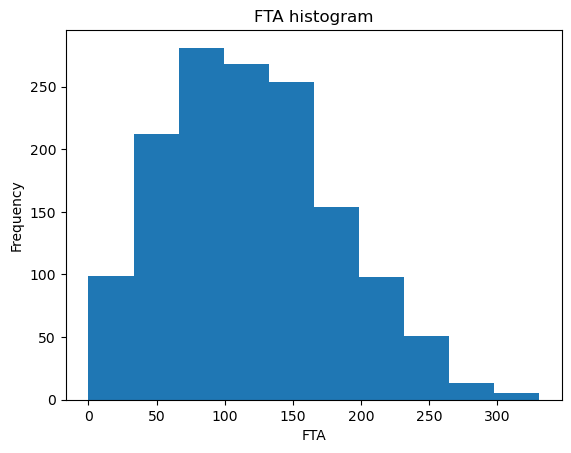

min: 0, max: 331, mean: 119.44250871080139, median: 114.0, stdev: 61.48807873350707


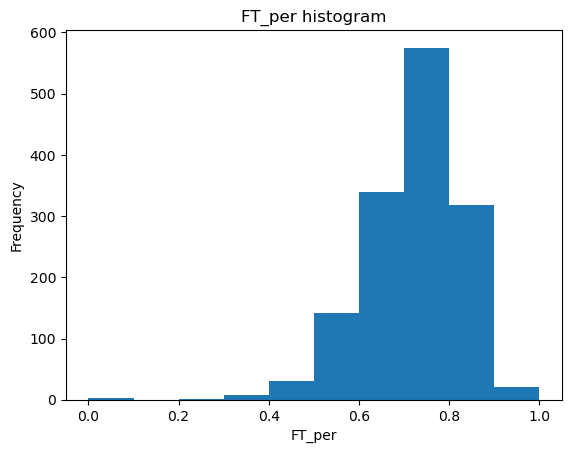

min: 0.0, max: 1.0, mean: 0.7225937282229965, median: 0.737, stdev: 0.10542115888980476


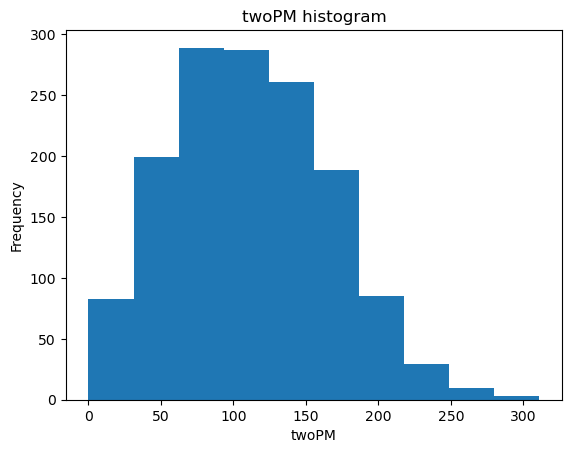

min: 0, max: 311, mean: 111.68432055749129, median: 109.0, stdev: 53.96603868535748


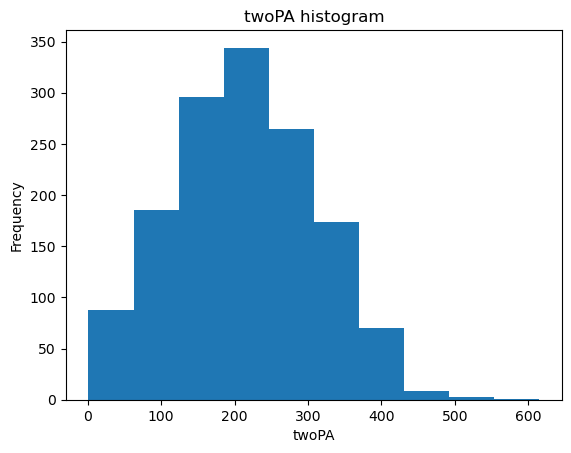

min: 1, max: 615, mean: 213.18745644599304, median: 211.0, stdev: 97.18448062068278


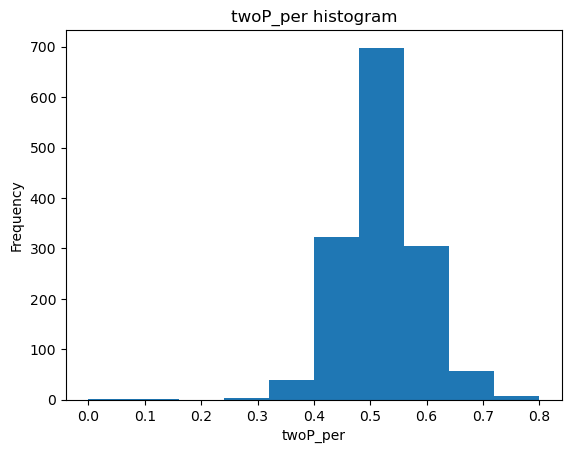

min: 0.0, max: 0.8, mean: 0.5201038327526133, median: 0.517, stdev: 0.07020261336968135


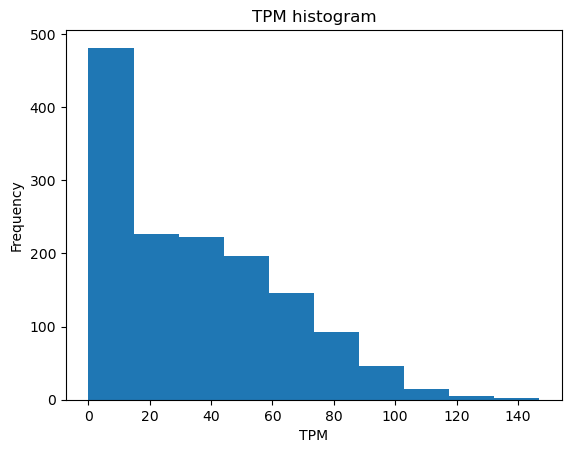

min: 0, max: 147, mean: 34.26202090592334, median: 30.0, stdev: 29.344577693086897


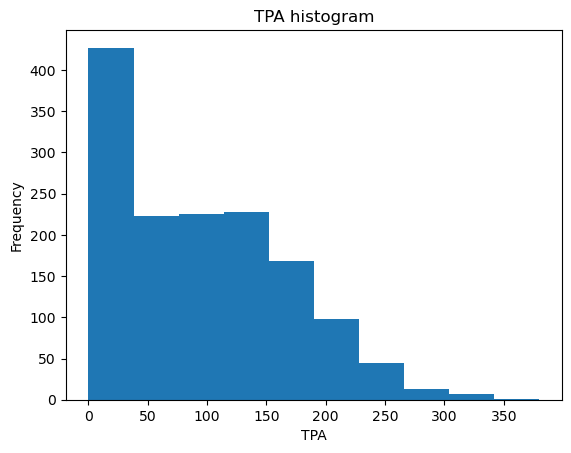

min: 0, max: 380, mean: 93.32822299651568, median: 87.0, stdev: 74.05656931114976


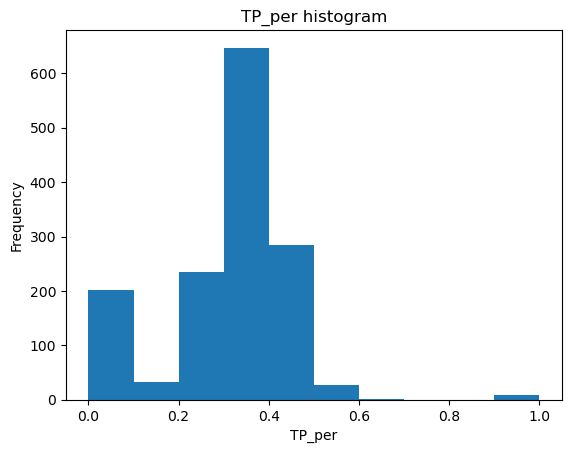

min: 0.0, max: 1.0, mean: 0.30656724738675956, median: 0.346, stdev: 0.14874682997835703


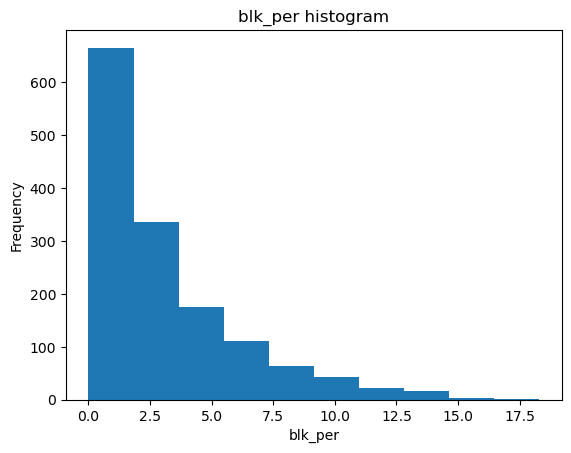

min: 0.0, max: 18.3, mean: 3.126411149825784, median: 2.0, stdev: 3.000224191695259


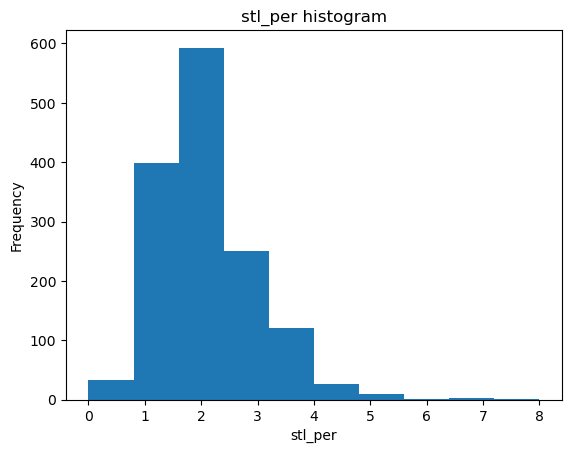

min: 0.0, max: 8.0, mean: 2.0767247386759586, median: 1.9, stdev: 0.8870927105872143


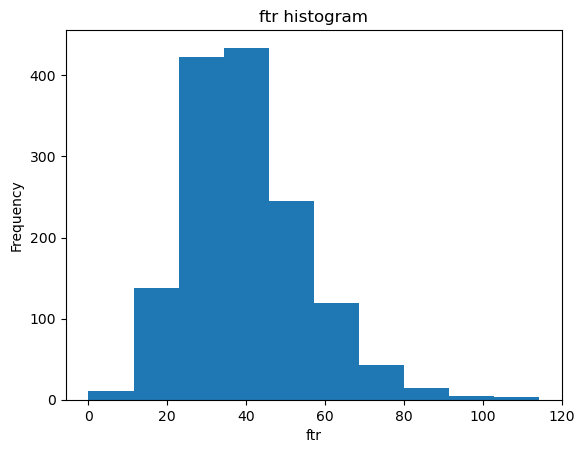

min: 0.0, max: 114.3, mean: 39.7993031358885, median: 38.1, stdev: 15.126319791033001


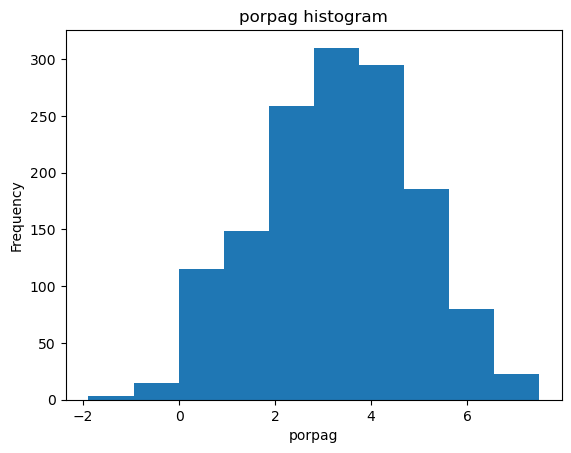

min: -1.887, max: 7.49948, mean: 3.291411809498258, median: 3.37162, stdev: 1.6055251784789417


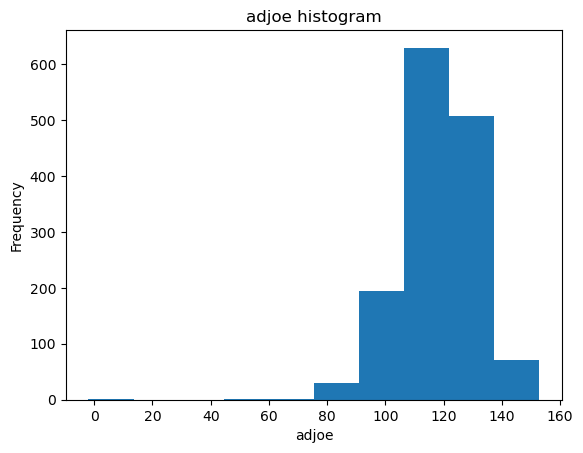

min: -1.98638, max: 152.849, mean: 118.15428064111498, median: 118.916, stdev: 12.881532936391881


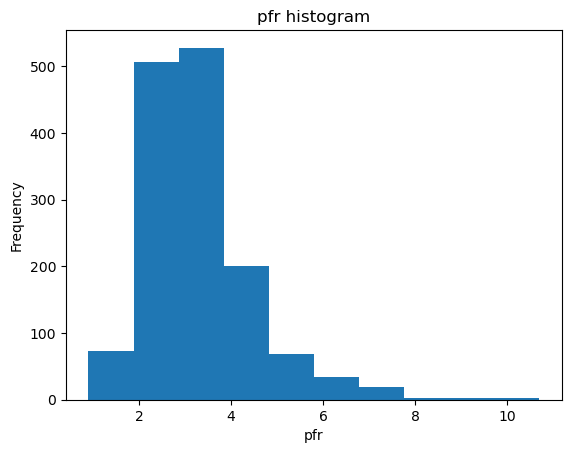

min: 0.9, max: 10.7, mean: 3.278188153310105, median: 3.1, stdev: 1.1674416501113196


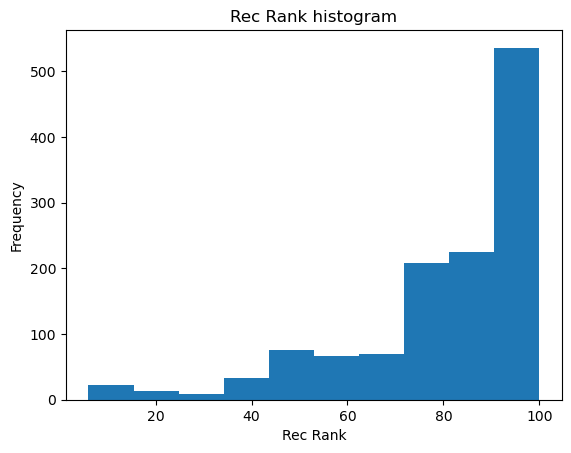

min: 6.0, max: 100.0, mean: 80.40476947535771, median: 87.2, stdev: 20.00695287622593


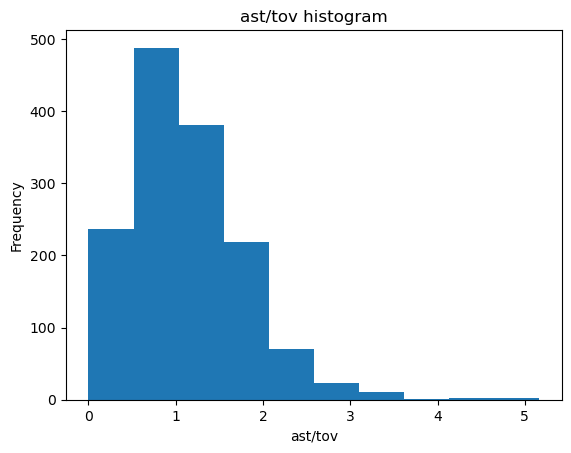

min: 0.0, max: 5.1666663, mean: 1.1281925817224547, median: 1.0283675300000001, stdev: 0.6529691704322309


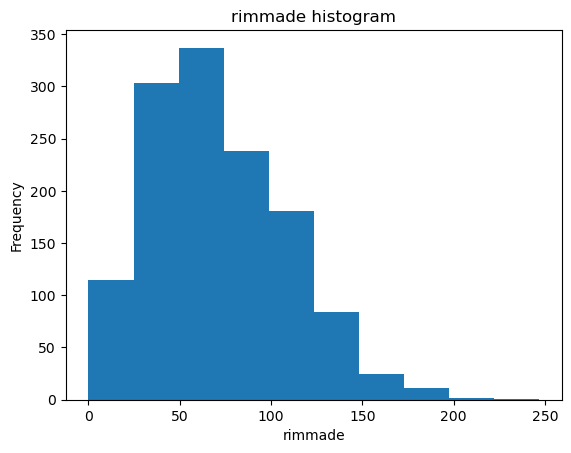

min: 0.0, max: 247.0, mean: 71.06476484194295, median: 66.0, stdev: 37.72357794725947


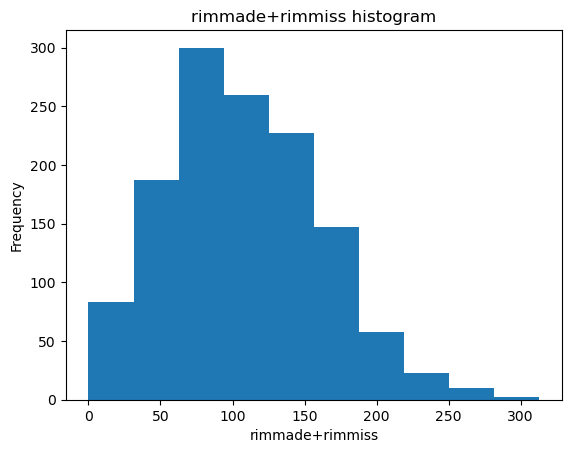

min: 0.0, max: 313.0, mean: 107.58365458750964, median: 101.0, stdev: 52.912264132092304


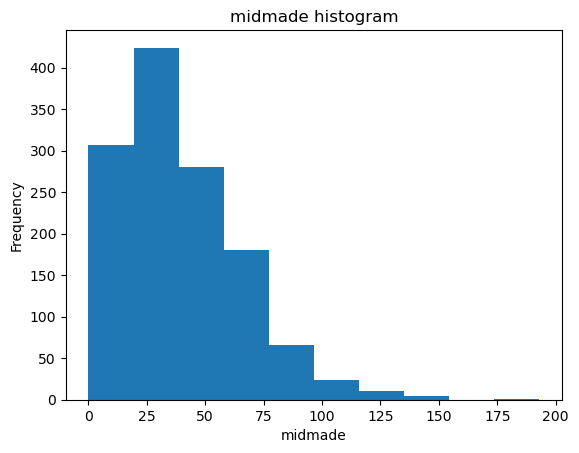

min: 0.0, max: 193.0, mean: 39.39167309175019, median: 35.0, stdev: 25.87653243015952


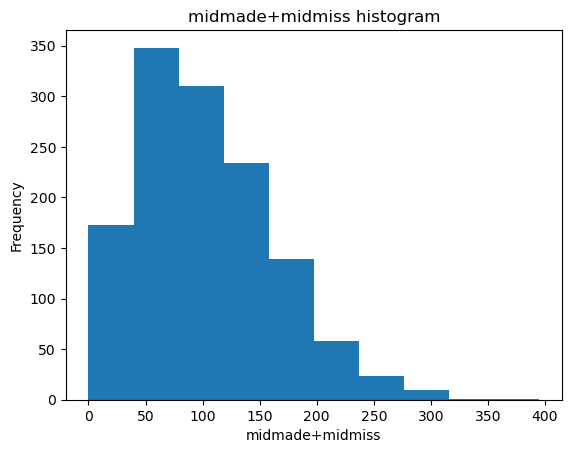

min: 0.0, max: 395.0, mean: 103.38010794140324, median: 96.0, stdev: 60.08306754182286


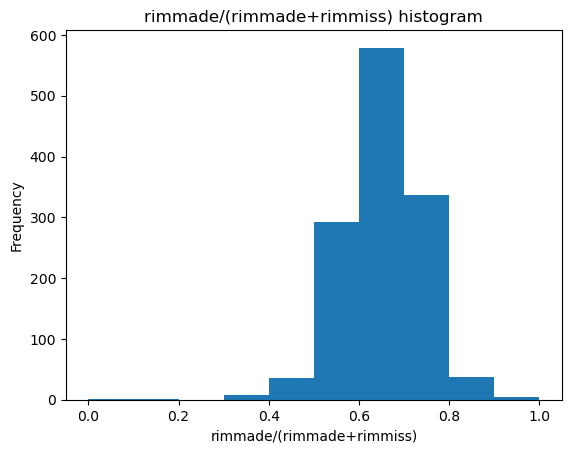

min: 0.0, max: 1.0, mean: 0.652682098765432, median: 0.6557, stdev: 0.08846648011540176


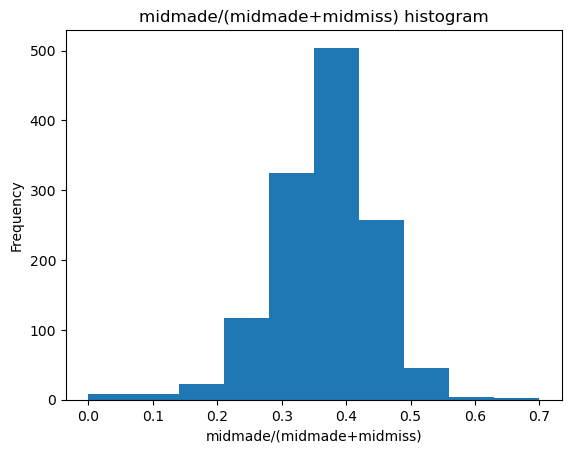

min: 0.0, max: 0.7, mean: 0.3669606949806949, median: 0.3723, stdev: 0.07929671095899152


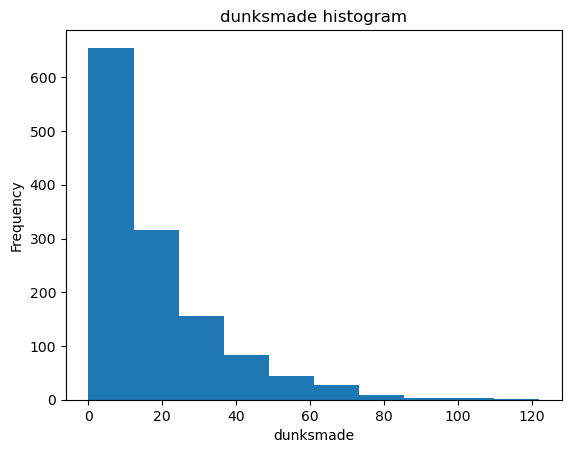

min: 0.0, max: 122.0, mean: 17.727062451811875, median: 12.0, stdev: 17.788351458585282


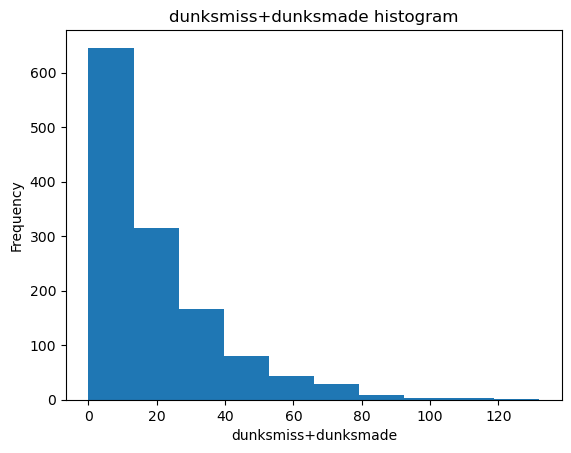

min: 0.0, max: 132.0, mean: 19.390902081727063, median: 14.0, stdev: 19.14073956228378


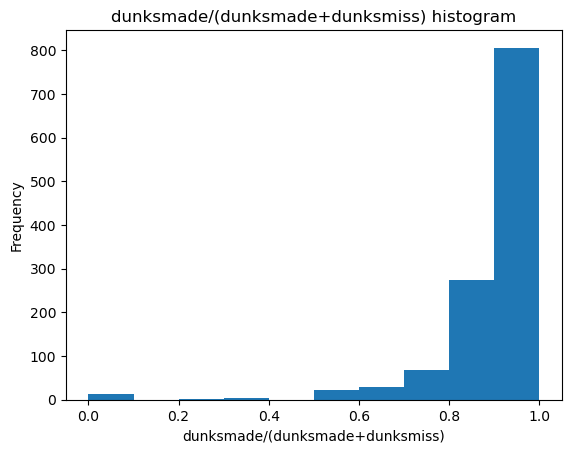

min: 0.0, max: 1.0, mean: 0.9021756177924217, median: 0.931, stdev: 0.13843513675525884


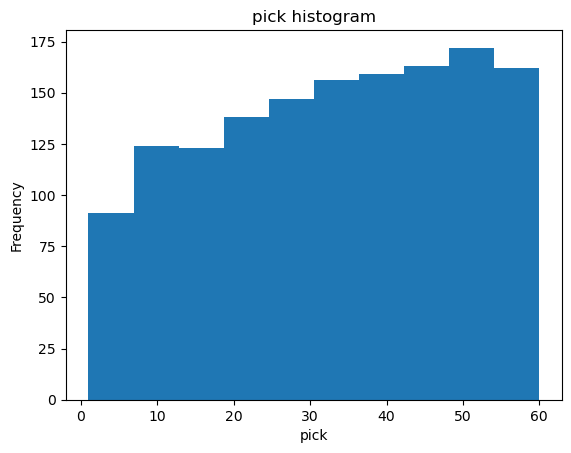

min: 1.0, max: 60.0, mean: 33.163763066202094, median: 34.0, stdev: 16.658404835376793


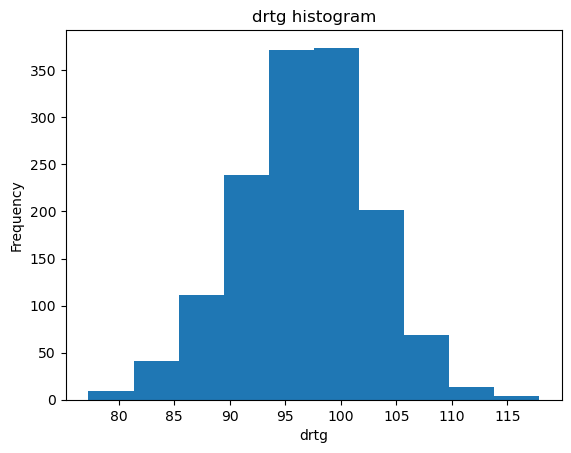

min: 77.2779, max: 117.885, mean: 96.82330536585367, median: 97.1049, stdev: 5.950088693090269


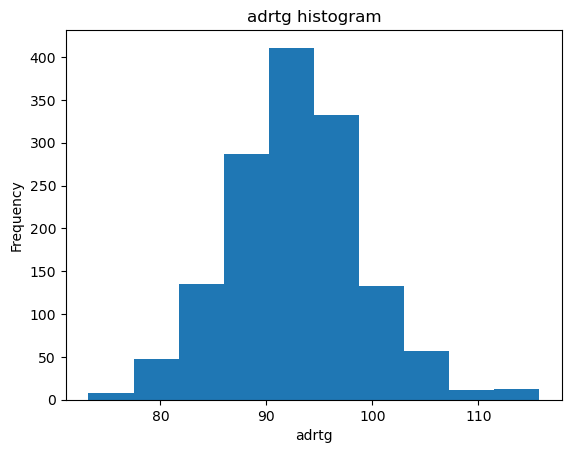

min: 73.2127, max: 115.743, mean: 92.76715986062717, median: 92.6626, stdev: 6.285847733643367


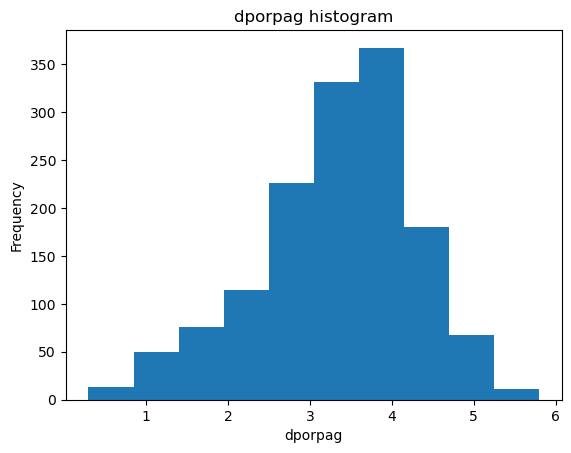

min: 0.293935, max: 5.80053, mean: 3.3362612536585368, median: 3.45722, stdev: 0.9540014172858856


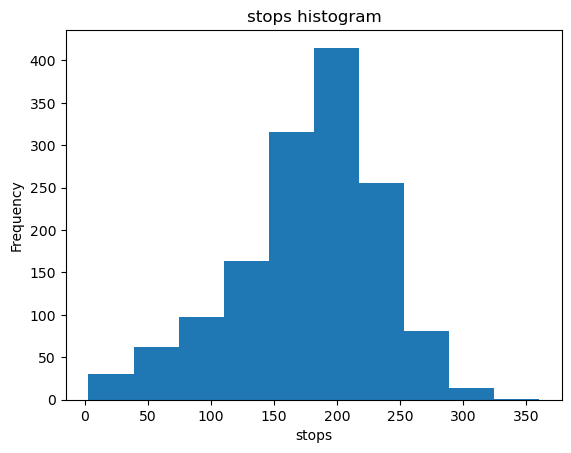

min: 3.07385, max: 360.572, mean: 177.9748604947735, median: 185.96, stdev: 57.52114029909782


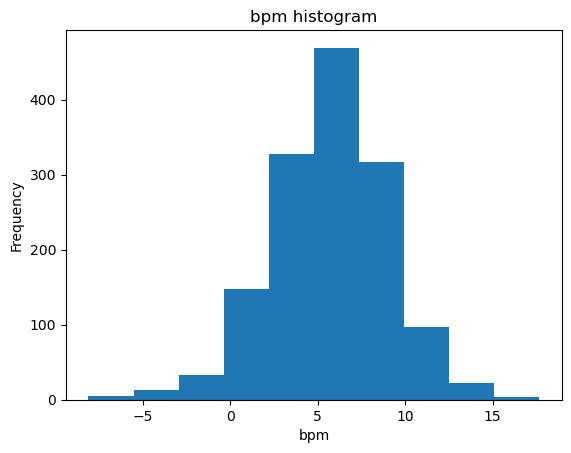

min: -8.09814, max: 17.668, mean: 5.700305786320558, median: 5.90853, stdev: 3.287325766759897


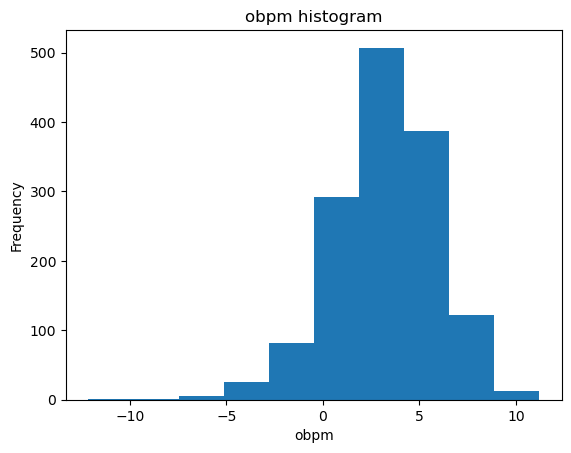

min: -12.1542, max: 11.2197, mean: 3.2231085234216024, median: 3.35271, stdev: 2.662537204440004


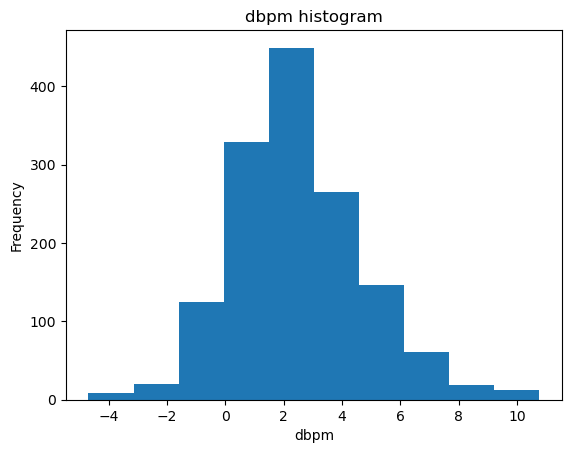

min: -4.69238, max: 10.7602, mean: 2.477197702940767, median: 2.25679, stdev: 2.231635713719515


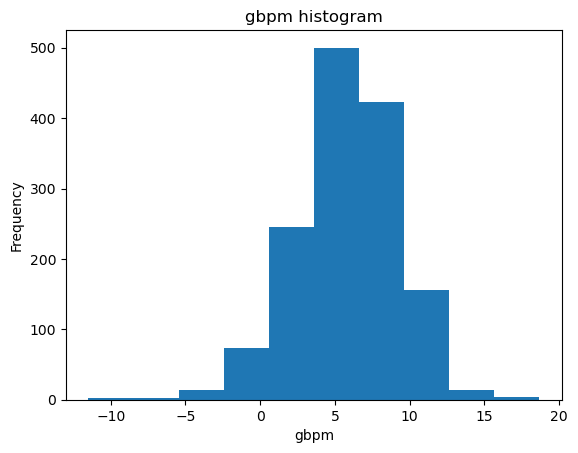

min: -11.4922, max: 18.6726, mean: 5.785684025783973, median: 5.87867, stdev: 3.392256680306739


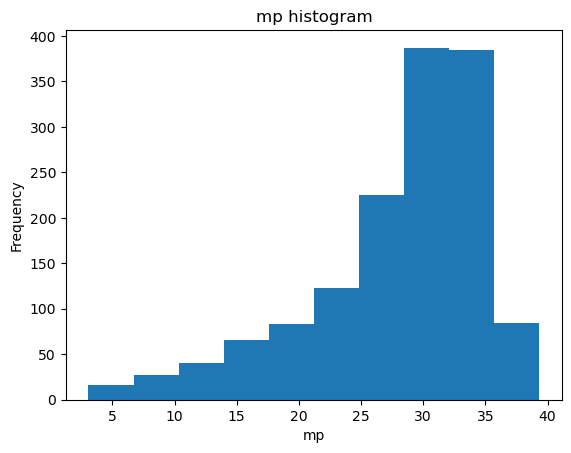

min: 3.0667, max: 39.3438, mean: 28.004257282229965, median: 30.0263, stdev: 7.026189342259823


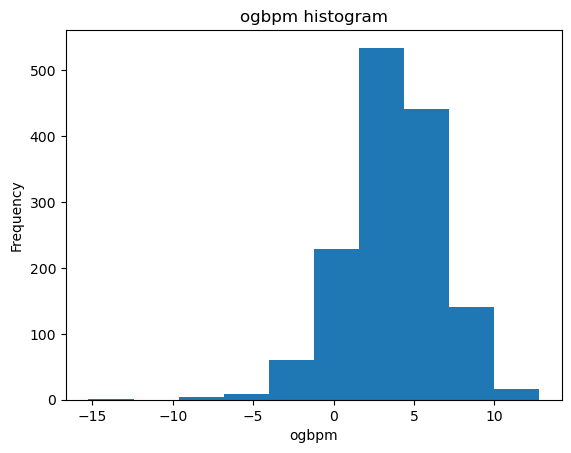

min: -15.2471, max: 12.8016, mean: 3.682969851777004, median: 3.85584, stdev: 2.9112236066769266


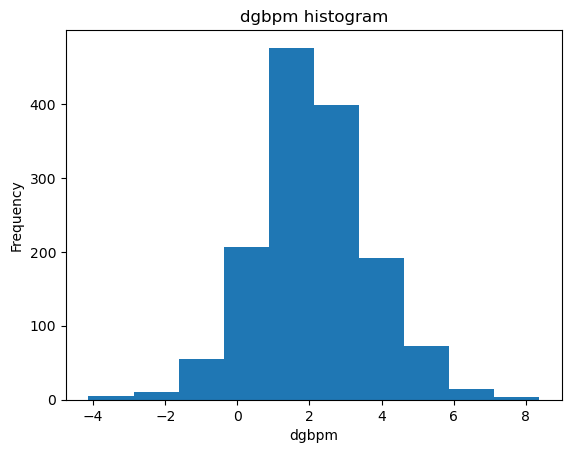

min: -4.13172, max: 8.3762, mean: 2.1027148815818815, median: 2.01473, stdev: 1.583098245480285


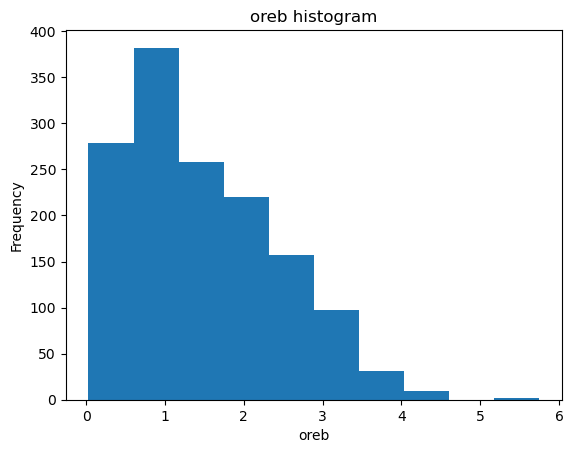

min: 0.0294, max: 5.75, mean: 1.4876608362369337, median: 1.2903, stdev: 0.938980458042166


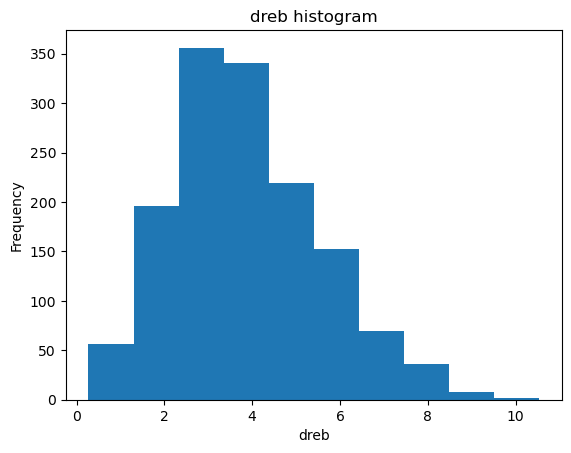

min: 0.2692, max: 10.5429, mean: 3.872030940766551, median: 3.6471, stdev: 1.684025409916854


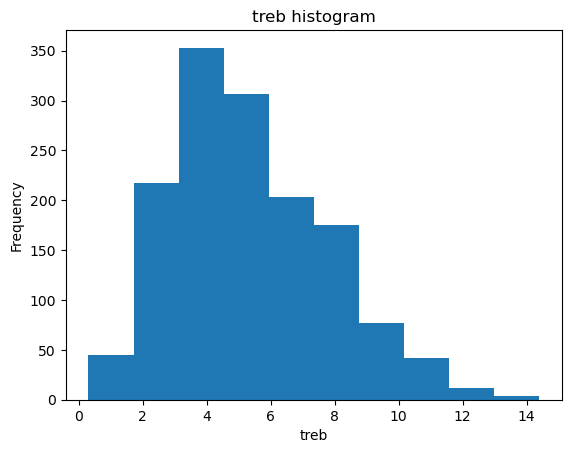

min: 0.3077, max: 14.4, mean: 5.359693101045296, median: 4.9429, stdev: 2.422036518183121


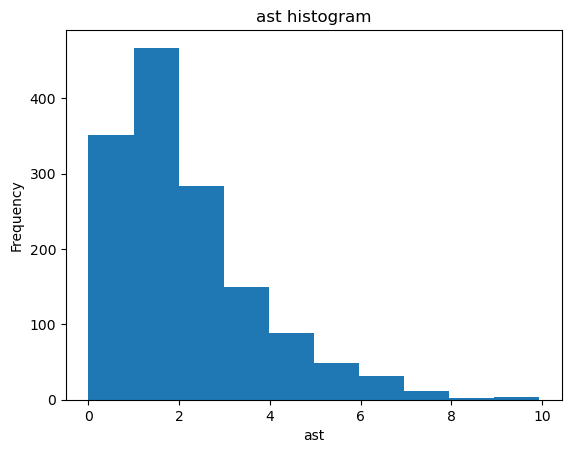

min: 0.0, max: 9.9394, mean: 2.1497101045296167, median: 1.7308, stdev: 1.5779954218555692


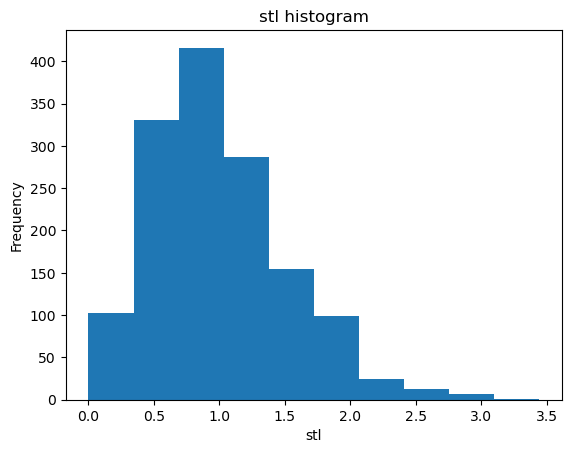

min: 0.0, max: 3.4444, mean: 0.9985699651567945, median: 0.931, stdev: 0.513997724609181


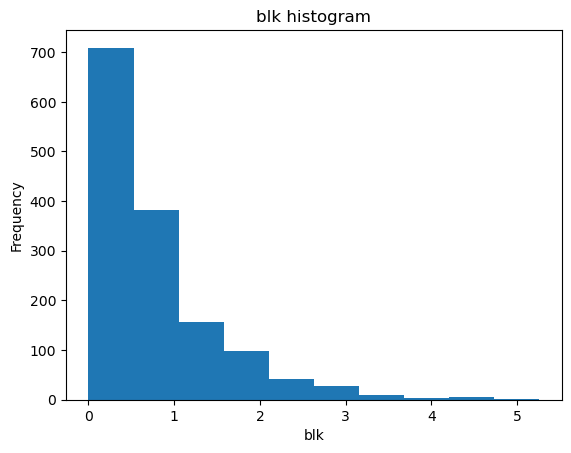

min: 0.0, max: 5.2581, mean: 0.7681149825783972, median: 0.5294, stdev: 0.7472677273490606


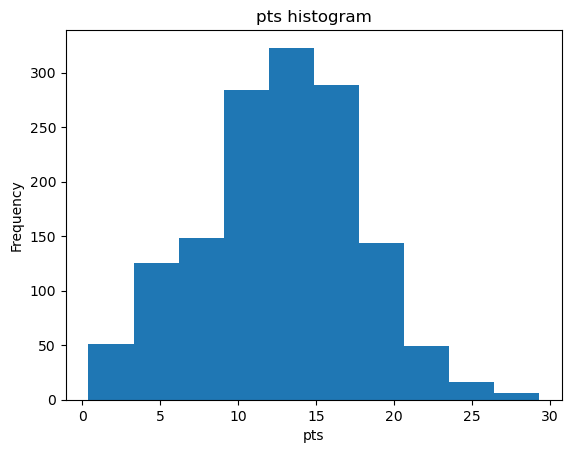

min: 0.4, max: 29.3056, mean: 12.719892264808363, median: 12.9143, stdev: 5.048082328993433


In [9]:
# Looking at and verifying histograms for each of the wanted_stats before weighting & normalization.

def hist(df,stat): # Create histogram from the stat vector in the given DataFrame
    df[stat].plot(kind='hist', x=stat, xlabel=stat, title=stat+' histogram')
    plt.show()
    print(f"min: {df[stat].min()}, max: {df[stat].max()}, mean: {df[stat].mean()}, median: {df[stat].median()}, stdev: {df[stat].std()}")

unwanted_stats = ["player_name","team","conf","yr","ht","num","year","pid","type","position"]
wanted_stats = [ele for ele in ncaa_df.columns if ele not in unwanted_stats]

for stat in wanted_stats:
    hist(ncaa_df,stat)

## Train Random Forest Regressor with the Best Parameters According to Bayesian Optimization

In [10]:
from sklearn.model_selection import train_test_split

feature_df = weighted_df.select_dtypes(include='number').drop(["year","pick"],axis=1) 
X = feature_df.values # Features used to predict draft pick
y = weighted_df["pick"].values # Draft pick

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # Train test split

from skopt import BayesSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import time

start_time = time.time()

# Deciding best Random Forest Regressor Hyperparameters from reasonably wide ranges using Bayesian Optimization

b_cv = BayesSearchCV(RandomForestRegressor(oob_score=True), 
                     {'min_samples_leaf': np.arange(3,15),
                      'n_estimators': np.arange(40,100),
                      'min_weight_fraction_leaf': np.arange(0.1,1,20),
                      'max_depth': np.arange(4,15),
                      'min_samples_split': np.arange(4,20),
                      'criterion': ("squared_error", "absolute_error", "friedman_mse", "poisson"),
                      'max_features': ('sqrt', 'log2', None, 0.1, 0.5, 1, 5, 10)}, 
                     scoring=make_scorer(r2_score), 
                     n_iter=50, 
                     cv=5, 
                     random_state=0)

b_cv.fit(X_train, y_train)

regressor = b_cv.best_estimator_

print(f"Bayes Optimization Search time: {time.time() - start_time}")

display(regressor)

Bayes Optimization Search time: 286.54874873161316


RandomForestRegressor(criterion='poisson', max_depth=5, max_features=0.5,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.1, n_estimators=64,
                      oob_score=True)

## Testing Regressor

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

print(f'Out-of-Bag Score: {regressor.oob_score_}')

print('\nScores on training data')
predictions_train = regressor.predict(X_train)
print(f'Mean Squared Error: {mean_squared_error(y_train, predictions_train)}')
print(f'R-squared: {r2_score(y_train, predictions_train)}')


print('\nScores on testing data')
predictions_test = regressor.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, predictions_test)}')
print(f'R-squared: {r2_score(y_test, predictions_test)}')


Out-of-Bag Score: 0.2727526852509078

Scores on training data
Mean Squared Error: 179.36806769087568
R-squared: 0.399067300996385

Scores on testing data
Mean Squared Error: 211.44711782505576
R-squared: 0.24139217703667437


## Feature Importances According to Random Forest Regressor

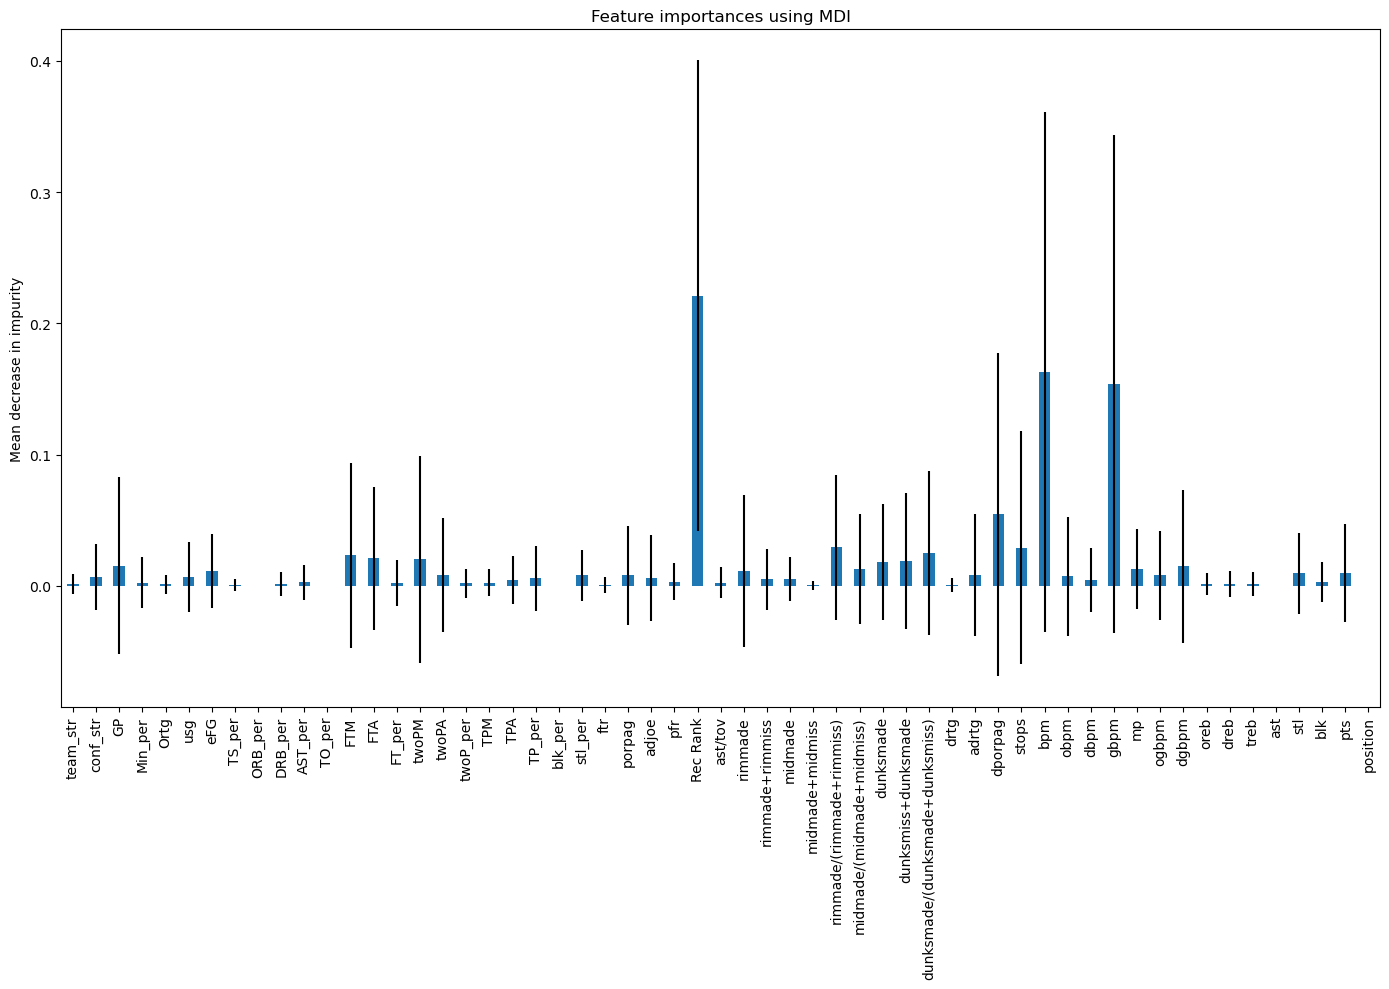

In [12]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)
fig, ax = plt.subplots()
pd.Series(importances, feature_df.columns).plot.bar(yerr=std, ax=ax, figsize=(14,10))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Plotting Model Accuracy

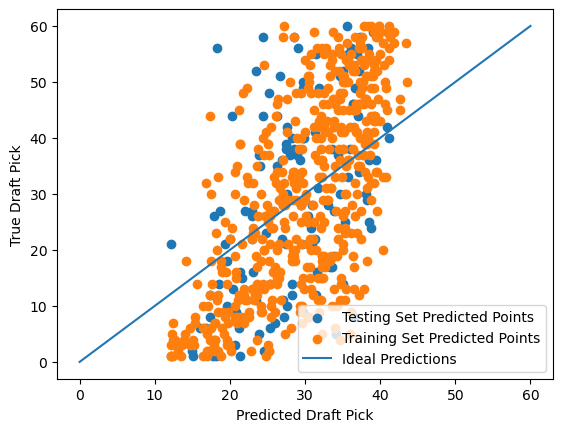

In [13]:
# Plotting predicted pick vs. true pick

plt.scatter(predictions_test,y_test,label='Testing Set Predicted Points')
plt.scatter(predictions_train,y_train,label='Training Set Predicted Points')
plt.plot([0,60],[0,60],label='Ideal Predictions')
plt.xlabel('Predicted Draft Pick')
plt.ylabel('True Draft Pick')
plt.legend()
plt.show()

## Visualizing a Tree in the Random Forest Regressor

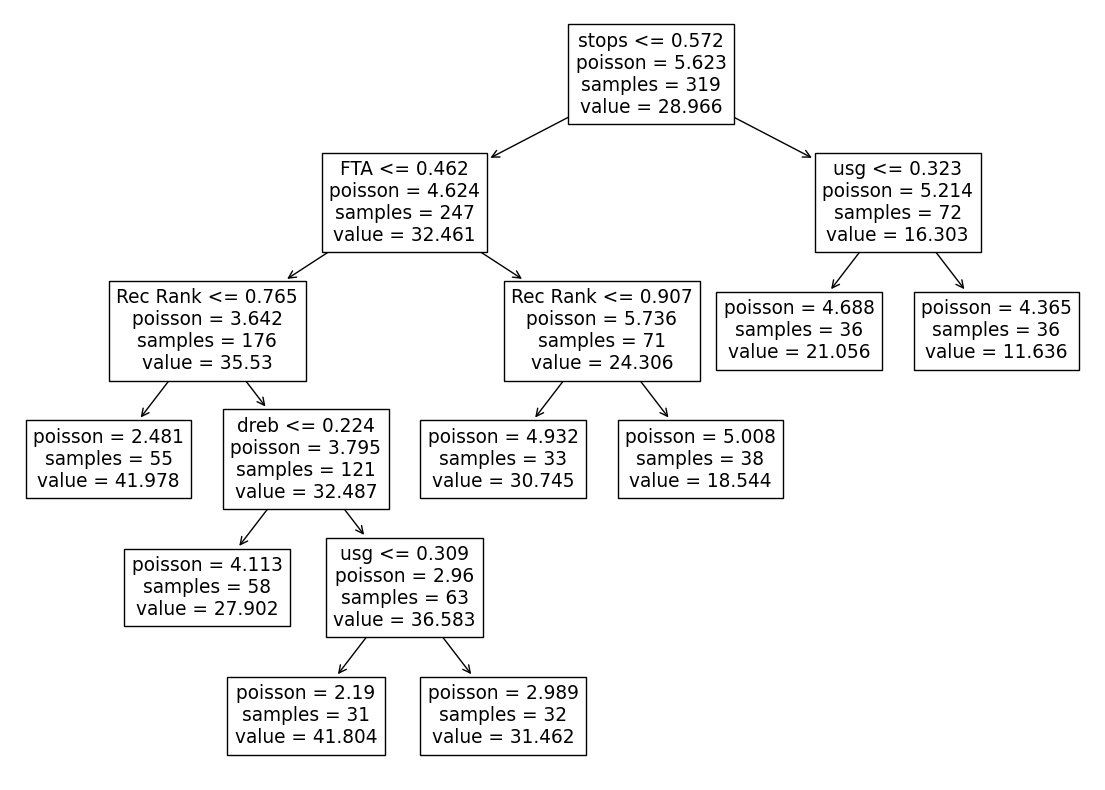

In [14]:
from sklearn import tree

unwanted_fields = ["player_name","team","conf","yr","ht","num","year","pid","type","position","pick"]
wanted_fields = [ele for ele in ncaa_df.columns if ele not in unwanted_stats]    

plt.figure(figsize=(14,10))
tree.plot_tree(regressor[0], feature_names = wanted_fields, class_names = np.arange(1,61))
plt.show()